In [91]:
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, average_precision_score,\
    roc_auc_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
import sys, re
from collections import OrderedDict
import seaborn as sns
from sklearn import preprocessing
import _pickle as pickle
from sklearn import tree
from sklearn import svm

In [92]:
seed = 142
pd.options.display.max_columns = 50
np.random.seed(seed)

### Import data and check some stats

In [93]:
order_data = pd.read_csv('machine_learning_challenge_order_data.csv')
order_data.shape

(786600, 13)

In [94]:
len(pd.unique(order_data['customer_id']))

245455

In [95]:
order_data.head()

,customer_id,order_date,order_hour,customer_order_rank,is_failed,voucher_amount,delivery_fee,amount_paid,restaurant_id,city_id,payment_id,platform_id,transmission_id
0,000097eabfd9,2015-06-20,19,1.0,0,0.0,0.000,11.46960,5803498,20326,1779,30231,4356
1,0000e2c6d9be,2016-01-29,20,1.0,0,0.0,0.000,9.55800,239303498,76547,1619,30359,4356
2,000133bb597f,2017-02-26,19,1.0,0,0.0,0.493,5.93658,206463498,33833,1619,30359,4324
3,00018269939b,2017-02-05,17,1.0,0,0.0,0.493,9.82350,36613498,99315,1619,30359,4356
4,0001a00468a6,2015-08-04,19,1.0,0,0.0,0.493,5.15070,225853498,16456,1619,29463,4356


In [96]:
order_data.dtypes

customer_id             object
order_date              object
order_hour               int64
customer_order_rank    float64
is_failed                int64
voucher_amount         float64
delivery_fee           float64
amount_paid            float64
restaurant_id            int64
city_id                  int64
payment_id               int64
platform_id              int64
transmission_id          int64
dtype: object

In [97]:
order_data.isna().sum(axis=0)

customer_id                0
order_date                 0
order_hour                 0
customer_order_rank    24767
is_failed                  0
voucher_amount             0
delivery_fee               0
amount_paid                0
restaurant_id              0
city_id                    0
payment_id                 0
platform_id                0
transmission_id            0
dtype: int64

In [98]:
order_data.loc[:, 'customer_order_rank':'amount_paid'].mean(axis=0)

customer_order_rank     9.436810
is_failed               0.031486
voucher_amount          0.091489
delivery_fee            0.181180
amount_paid            10.183271
dtype: float64

In [99]:
order_data['restaurant_id'].value_counts().shape[0],\
order_data['city_id'].value_counts().shape[0],\
order_data['payment_id'].value_counts().shape[0],\
order_data['platform_id'].value_counts().shape[0],\
order_data['transmission_id'].value_counts().shape[0]

(13569, 3749, 5, 14, 10)

In [100]:
labeled_data = pd.read_csv('machine_learning_challenge_labeled_data.csv')
labeled_data.shape

(786600, 13)

In [13]:
labeled_data.head()

,customer_id,is_returning_customer
0,000097eabfd9,0
1,0000e2c6d9be,0
2,000133bb597f,1
3,00018269939b,0
4,0001a00468a6,0


In [14]:
labeled_data.dtypes

customer_id              object
is_returning_customer     int64
dtype: object

In [15]:
labeled_data['is_returning_customer'].mean(axis=0)

0.22613921085331323

### Simple transformation of a client to one row data

In [101]:
payment_id_dummies = pd.get_dummies(order_data['payment_id'], prefix='payment_id')
platform_id_dummies = pd.get_dummies(order_data['platform_id'], prefix='platform_id')
transmission_id_dummies = pd.get_dummies(order_data['transmission_id'], prefix='transmission_id')
dummies = [payment_id_dummies, platform_id_dummies, transmission_id_dummies]
# order_data.drop(['payment_id', 'platform_id', 'transmission_id'], axis=1, inplace=True)
order_data = pd.concat([order_data]+dummies, axis=1)
order_data.shape

(786600, 42)

In [102]:
order_data.columns

Index(['customer_id', 'order_date', 'order_hour', 'customer_order_rank',
       'is_failed', 'voucher_amount', 'delivery_fee', 'amount_paid',
       'restaurant_id', 'city_id', 'payment_id', 'platform_id',
       'transmission_id', 'payment_id_1491', 'payment_id_1523',
       'payment_id_1619', 'payment_id_1779', 'payment_id_1811',
       'platform_id_525', 'platform_id_22167', 'platform_id_22263',
       'platform_id_22295', 'platform_id_29463', 'platform_id_29495',
       'platform_id_29751', 'platform_id_29815', 'platform_id_30135',
       'platform_id_30199', 'platform_id_30231', 'platform_id_30359',
       'platform_id_30391', 'platform_id_30423', 'transmission_id_212',
       'transmission_id_1988', 'transmission_id_2020', 'transmission_id_4196',
       'transmission_id_4228', 'transmission_id_4260', 'transmission_id_4324',
       'transmission_id_4356', 'transmission_id_4996',
       'transmission_id_21124'],
      dtype='object')

In [18]:
payment_cols = order_data.filter(regex='^payment_id_', axis=1).columns.tolist()
platform_cols = order_data.filter(regex='^platform_id_', axis=1).columns.tolist()
transmission_cols = order_data.filter(regex='^transmission_id_', axis=1).columns.tolist()

# Aggregate input dataframe columns
def custom_aggregate(df):
    df_agg = {}
    df_agg['customer_id'] = pd.unique(df['customer_id'])[0]
    df_agg['orders_num'] = len(df)
    df_agg['is_failed_num'] = np.sum(df['is_failed'])
    df_agg['voucher_amount_sum'] = np.sum(df['voucher_amount'])
    df_agg['delivery_fee_mean'] = np.mean(df['delivery_fee'])
    df_agg['delivery_fee_sum'] = np.sum(df['delivery_fee'])
    df_agg['delivery_fee_num'] = np.sum(df['delivery_fee'] > 0.)
    df_agg['restaurant_id_unq_num'] = len(pd.unique(df['restaurant_id']))
    df_agg['city_id_unq_num'] = len(pd.unique(df['city_id']))
    df_agg['payment_id_unq_num'] = len(pd.unique(df['payment_id']))
    df_agg['platform_id_unq_num'] = len(pd.unique(df['platform_id']))
    df_agg['transmission_id_unq_num'] = len(pd.unique(df['transmission_id']))
    df_agg['amount_paid_mean'] = np.mean(df['amount_paid'])
    df_agg['amount_paid_sum'] = np.sum(df['amount_paid'])
    df_agg['amount_paid_std'] = np.std(df['amount_paid'])
    df_agg['amount_paid_quantile75'] = df['amount_paid'].quantile(q=0.75)
    
    # aggregate payment dummy columns
    payment_cols_new = [col+'_num' for col in payment_cols]
    df_agg.update(dict(zip(payment_cols_new, df[payment_cols].apply(np.sum))))
    
    # aggregate platform dummy columns
    platform_cols_new = [col+'_num' for col in platform_cols]
    df_agg.update(dict(zip(platform_cols_new, df[platform_cols].apply(np.sum))))
    
    # aggregate transmission dummy columns
    transmission_cols_new = [col+'_num' for col in transmission_cols]
    df_agg.update(dict(zip(transmission_cols_new, df[transmission_cols].apply(np.sum))))
    
    return pd.Series(OrderedDict(df_agg))

In [103]:
orders_per_client = order_data.groupby('customer_id', as_index=False).apply(custom_aggregate)

NameError: name 'custom_aggregate' is not defined

In [104]:
orders_per_client.head()

,customer_id,orders_num,is_failed_num,voucher_amount_sum,delivery_fee_mean,delivery_fee_sum,delivery_fee_num,restaurant_id_unq_num,city_id_unq_num,payment_id_unq_num,platform_id_unq_num,transmission_id_unq_num,amount_paid_mean,amount_paid_sum,amount_paid_std,amount_paid_quantile75,payment_id_1491_num,payment_id_1523_num,payment_id_1619_num,payment_id_1779_num,payment_id_1811_num,platform_id_525_num,platform_id_22167_num,platform_id_22263_num,platform_id_22295_num,platform_id_29463_num,platform_id_29495_num,platform_id_29751_num,platform_id_29815_num,platform_id_30135_num,platform_id_30199_num,platform_id_30231_num,platform_id_30359_num,platform_id_30391_num,platform_id_30423_num,transmission_id_212_num,transmission_id_1988_num,transmission_id_2020_num,transmission_id_4196_num,transmission_id_4228_num,transmission_id_4260_num,transmission_id_4324_num,transmission_id_4356_num,transmission_id_4996_num,transmission_id_21124_num
0,000097eabfd9,1,0,0.0,0.000,0.000,0,1,1,1,1,1,11.46960,11.46960,0.0,11.46960,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0000e2c6d9be,1,0,0.0,0.000,0.000,0,1,1,1,1,1,9.55800,9.55800,0.0,9.55800,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,000133bb597f,1,0,0.0,0.493,0.493,1,1,1,1,1,1,5.93658,5.93658,0.0,5.93658,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
3,00018269939b,1,0,0.0,0.493,0.493,1,1,1,1,1,1,9.82350,9.82350,0.0,9.82350,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0001a00468a6,1,0,0.0,0.493,0.493,1,1,1,1,1,1,5.15070,5.15070,0.0,5.15070,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
orders_per_client.shape, orders_per_client.columns

In [ ]:
orders_per_client.dtypes

In [105]:
# save dataframe
# orders_per_client.to_feather('orders_per_client.feather')
orders_per_client = pd.read_feather('orders_per_client.feather')

In [117]:
# tmp = order_data[order_data['customer_id'].isin(['000097eabfd9', '0004017c62e8', '003d7bb4de0d'])]
# grouped_tmp = tmp.groupby('customer_id', as_index=False)
# tmp_agg = grouped_tmp.apply(custom_aggregate)
# tmp_agg

,customer_id,orders_num,is_failed_num,voucher_amount_sum,delivery_fee_mean,delivery_fee_sum,delivery_fee_num,restaurant_id_unq_num,city_id_unq_num,payment_id_unq_num,platform_id_unq_num,transmission_id_unq_num,amount_paid_mean,amount_paid_sum,amount_paid_std,amount_paid_quantile75,payment_id_1491_num,payment_id_1523_num,payment_id_1619_num,payment_id_1779_num,payment_id_1811_num,platform_id_525_num,platform_id_22167_num,platform_id_22263_num,platform_id_22295_num,platform_id_29463_num,platform_id_29495_num,platform_id_29751_num,platform_id_29815_num,platform_id_30135_num,platform_id_30199_num,platform_id_30231_num,platform_id_30359_num,platform_id_30391_num,platform_id_30423_num,transmission_id_212_num,transmission_id_1988_num,transmission_id_2020_num,transmission_id_4196_num,transmission_id_4228_num,transmission_id_4260_num,transmission_id_4324_num,transmission_id_4356_num,transmission_id_4996_num,transmission_id_21124_num
0,000097eabfd9,1,0,0.0,0.000000,0.000,0,1,1,1,1,1,11.4696,11.4696,0.000000,11.4696,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0004017c62e8,5,0,0.0,0.000000,0.000,0,1,1,1,1,1,9.7173,48.5865,1.274400,10.3545,0,0,5,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0
2,003d7bb4de0d,3,0,0.0,0.328667,0.986,1,3,3,1,1,2,8.3898,25.1694,1.032382,8.8677,0,0,3,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0


In [110]:
# tmp_agg.loc[2, :]

amount_paid_mean                   8.3898
amount_paid_quantile75             8.8677
amount_paid_std                   1.03238
amount_paid_sum                   25.1694
city_id_unq_num                         3
customer_id                  003d7bb4de0d
delivery_fee_mean                0.328667
delivery_fee_num                        1
is_failed_num                           0
orders_num                              3
payment_id_1491_num                     0
payment_id_1523_num                     0
payment_id_1619_num                     3
payment_id_1779_num                     0
payment_id_1811_num                     0
payment_id_unq_num                      1
platform_id_22167_num                   0
platform_id_22263_num                   0
platform_id_22295_num                   0
platform_id_29463_num                   0
platform_id_29495_num                   0
platform_id_29751_num                   0
platform_id_29815_num                   3
platform_id_30135_num             

In [107]:
# tmp

,customer_id,order_date,order_hour,customer_order_rank,is_failed,voucher_amount,delivery_fee,amount_paid,restaurant_id,city_id,payment_id,platform_id,transmission_id,payment_id_1491,payment_id_1523,payment_id_1619,payment_id_1779,payment_id_1811,platform_id_525,platform_id_22167,platform_id_22263,platform_id_22295,platform_id_29463,platform_id_29495,platform_id_29751,platform_id_29815,platform_id_30135,platform_id_30199,platform_id_30231,platform_id_30359,platform_id_30391,platform_id_30423,transmission_id_212,transmission_id_1988,transmission_id_2020,transmission_id_4196,transmission_id_4228,transmission_id_4260,transmission_id_4324,transmission_id_4356,transmission_id_4996,transmission_id_21124
0,000097eabfd9,2015-06-20,19,1.0,0,0.0,0.000,11.4696,5803498,20326,1779,30231,4356,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
21,0004017c62e8,2017-01-15,17,1.0,0,0.0,0.000,10.3545,198823498,44854,1619,29815,4356,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
22,0004017c62e8,2017-01-26,19,2.0,0,0.0,0.000,11.9475,198823498,44854,1619,29815,4356,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
23,0004017c62e8,2017-02-05,16,3.0,0,0.0,0.000,8.7615,198823498,44854,1619,29815,4356,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
24,0004017c62e8,2017-02-12,17,4.0,0,0.0,0.000,8.7615,198823498,44854,1619,29815,4356,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
25,0004017c62e8,2017-02-15,18,5.0,0,0.0,0.000,8.7615,198823498,44854,1619,29815,4356,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
715,003d7bb4de0d,2016-04-22,21,1.0,0,0.0,0.000,9.8235,97653498,78478,1619,29815,4228,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
716,003d7bb4de0d,2016-10-02,21,2.0,0,0.0,0.000,7.4340,162733498,78206,1619,29815,4356,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
717,003d7bb4de0d,2016-12-07,19,3.0,0,0.0,0.986,7.9119,298863498,78693,1619,29815,4228,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [97]:
# for name, group in grouped:
#     if len(pd.unique(group['city_id'])) > 2 and len(group) < 5:
#         print(name)
#         break

003d7bb4de0d


In [65]:
# # grouped = order_data[['customer_id', 'amount_paid']].groupby('customer_id', as_index=False)
# # order_transform = grouped['amount_paid'].agg({'mean': np.mean, 
# #                                               'std': std, 
# #                                               'sum': np.sum,
# #                                               'count': 'count',
# #                                               'quantile75': quantile75})
# # aggregate some columns
# orders_agg = grouped.agg({'is_failed': np.sum,
#                           'voucher_amount': np.sum,
#                           'delivery_fee': np.mean,
#                           'restaurant_id': lambda x: len(pd.unique(x)),
#                           'city_id': lambda x: len(pd.unique(x)),
#                           'payment_id': lambda x: len(pd.unique(x)),
#                           'platform_id': lambda x: len(pd.unique(x)),
#                           'transmission_id': lambda x: len(pd.unique(x)),
#                           'amount_paid': [np.mean, np.sum, 
#                                           lambda x: np.std(np.array(x)), 
#                                           lambda x: x.quantile(q=0.75)]})
# # orders_agg.columns = ['customer_id', 'is_failed_sum', 'voucher_amount_sum',
# #                       'delivery_fee_mean', 'restaurant_id_unq_num', 'city_id_unq_num',
# #                       'payment_id_unq_num', 'platform_id_unq_num', 'transmission_id_unq_num']

KeyboardInterrupt: 

In [15]:
len(pd.unique(orders_per_client['city_id_unq_num'])), len(pd.unique(orders_per_client['restaurant_id_unq_num'])),\
np.mean(pd.unique(orders_per_client['city_id_unq_num'])), np.mean(pd.unique(orders_per_client['restaurant_id_unq_num']))

(16, 42, 10.5625, 22.357142857142858)

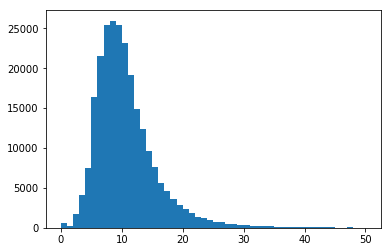

In [16]:
plt.hist(orders_per_client[orders_per_client['amount_paid_mean'] < 50]['amount_paid_mean'], bins=50)
plt.show()

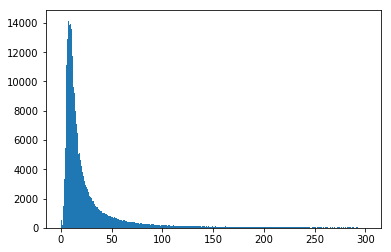

In [17]:
plt.hist(orders_per_client[orders_per_client['amount_paid_sum'] < 300]['amount_paid_sum'], bins=300)
plt.show()

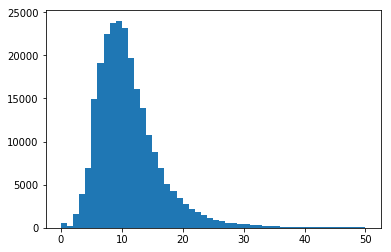

In [18]:
plt.hist(orders_per_client[orders_per_client['amount_paid_quantile75'] < 50]['amount_paid_quantile75'], bins=50)
plt.show()

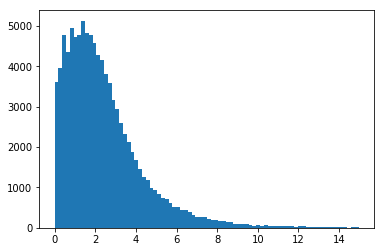

In [19]:
plt.hist(orders_per_client[(orders_per_client['amount_paid_std'] < 15) &\
                           (orders_per_client['amount_paid_std'] > 0)]['amount_paid_std'], bins=80)
plt.show()

In [20]:
orders_per_client[orders_per_client['amount_paid_std'] == 0].shape

(147350, 45)

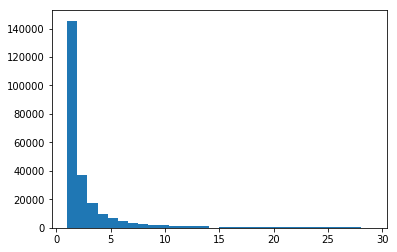

In [21]:
plt.hist(orders_per_client[orders_per_client['orders_num'] < 30]['orders_num'], bins=30)
plt.show()

Column : orders_num, Mean : 3.205, Median : 1.000, Std : 7.026


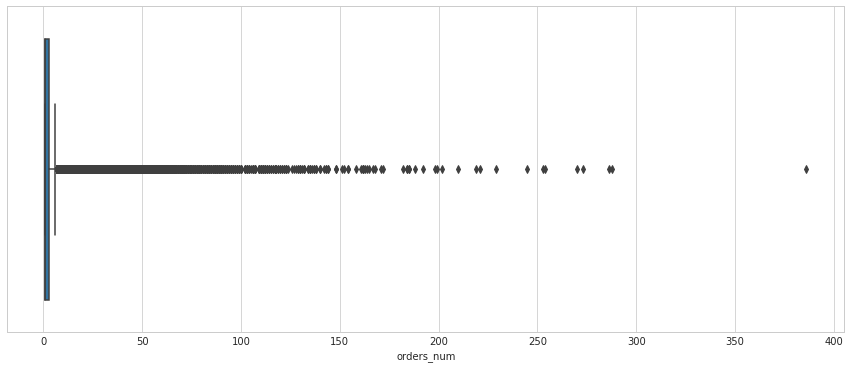

Column : is_failed_num, Mean : 0.101, Median : 0.000, Std : 0.656


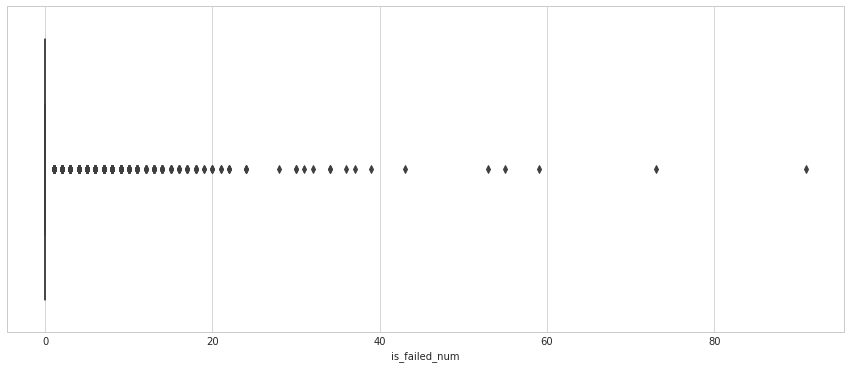

Column : voucher_amount_sum, Mean : 0.293, Median : 0.000, Std : 1.826


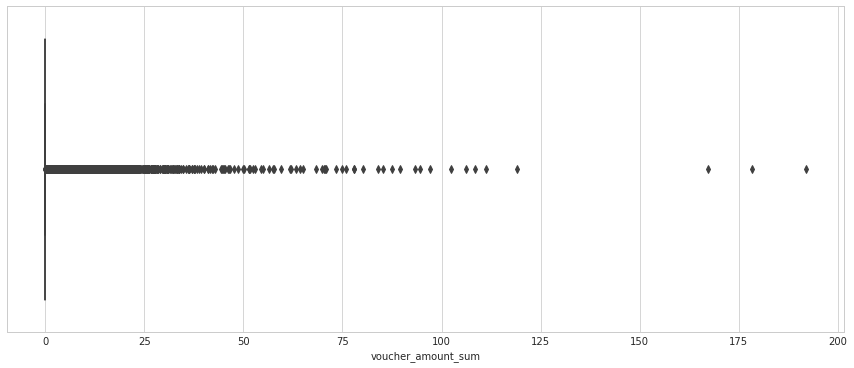

Column : delivery_fee_mean, Mean : 0.188, Median : 0.000, Std : 0.352


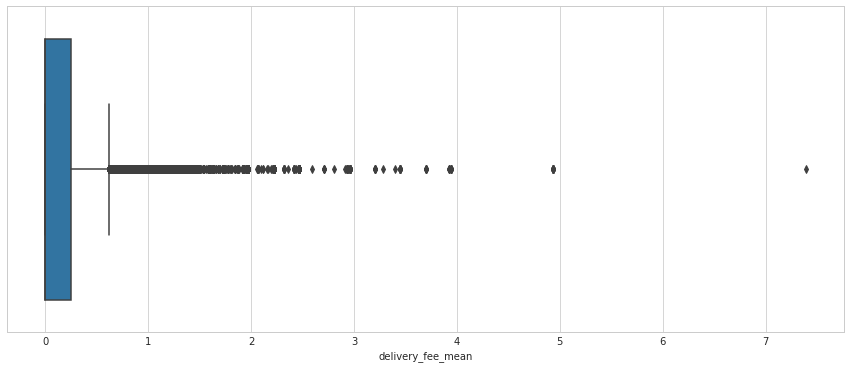

Column : delivery_fee_sum, Mean : 0.581, Median : 0.000, Std : 2.333


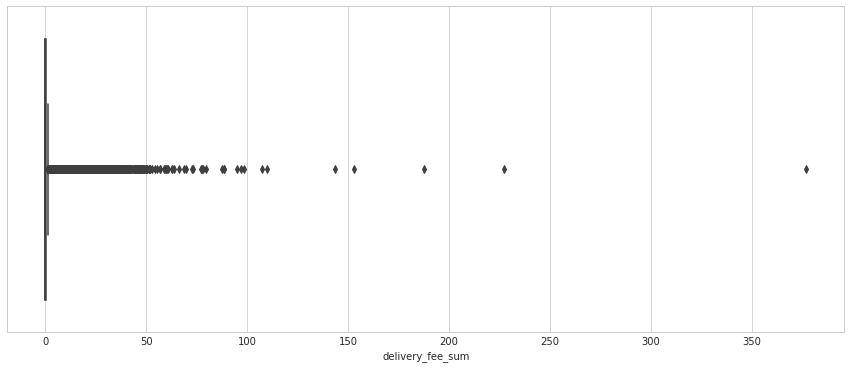

Column : delivery_fee_num, Mean : 0.770, Median : 0.000, Std : 2.821


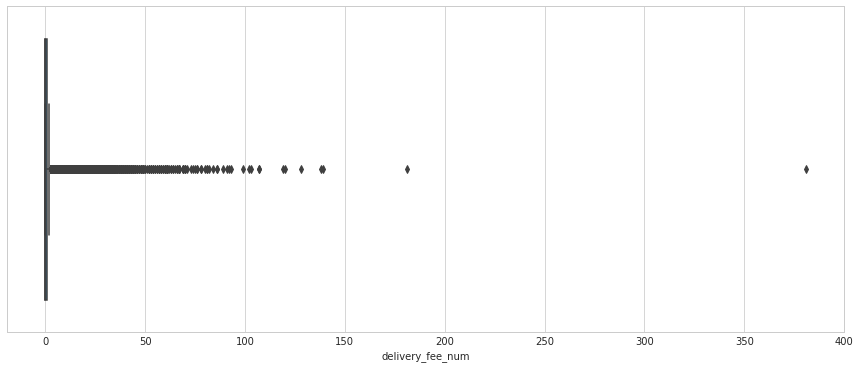

Column : restaurant_id_unq_num, Mean : 1.761, Median : 1.000, Std : 1.844


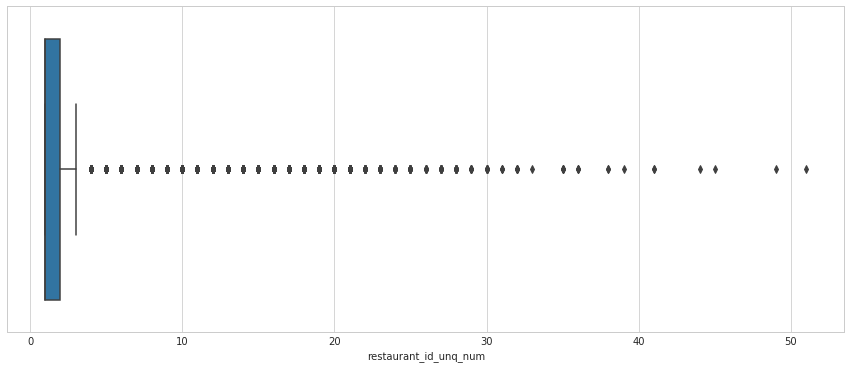

Column : city_id_unq_num, Mean : 1.045, Median : 1.000, Std : 0.263


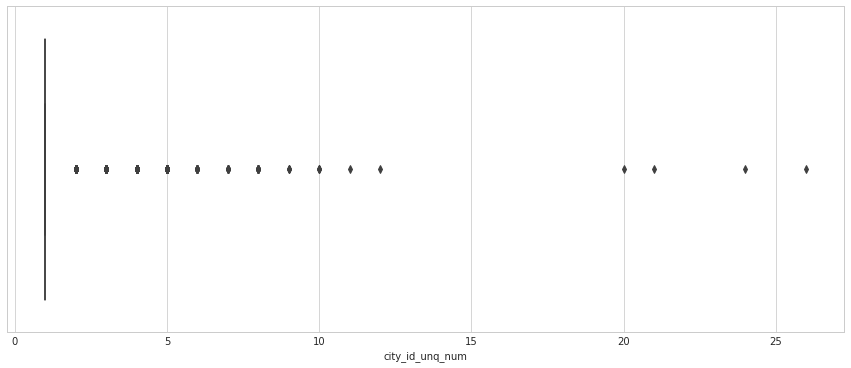

Column : payment_id_unq_num, Mean : 1.163, Median : 1.000, Std : 0.422


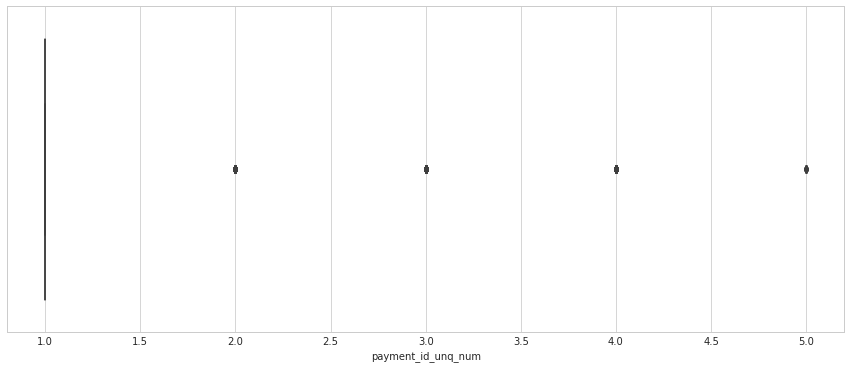

Column : platform_id_unq_num, Mean : 1.206, Median : 1.000, Std : 0.506


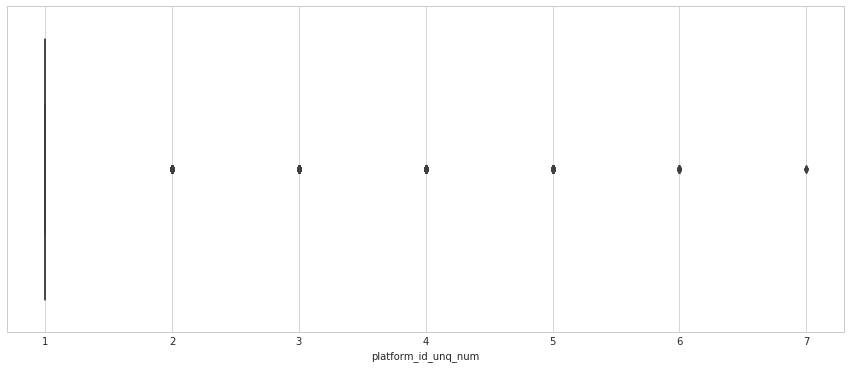

Column : transmission_id_unq_num, Mean : 1.366, Median : 1.000, Std : 0.710


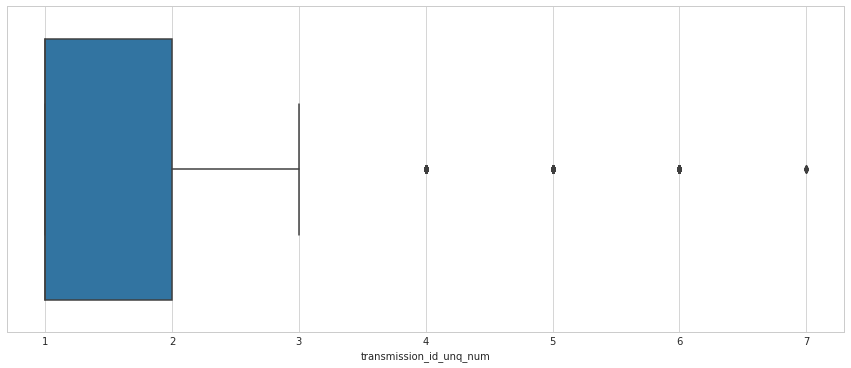

Column : amount_paid_mean, Mean : 10.807, Median : 9.717, Std : 5.799


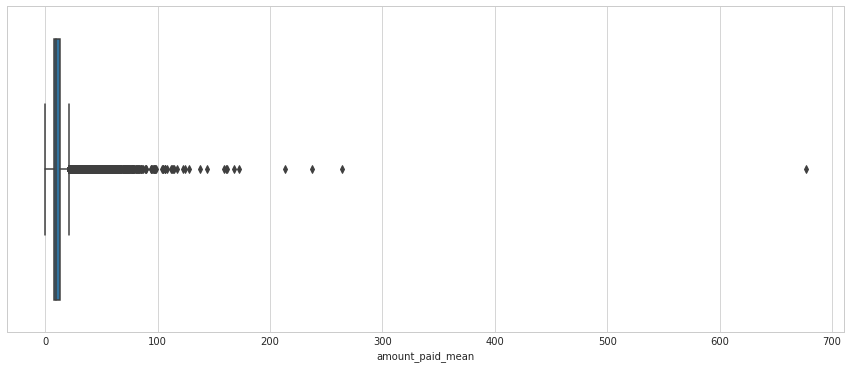

Column : amount_paid_sum, Mean : 32.634, Median : 14.178, Std : 70.026


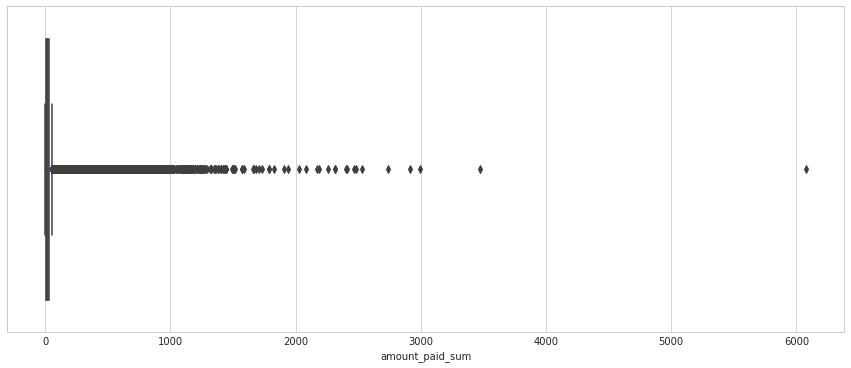

Column : amount_paid_std, Mean : 0.995, Median : 0.000, Std : 2.153


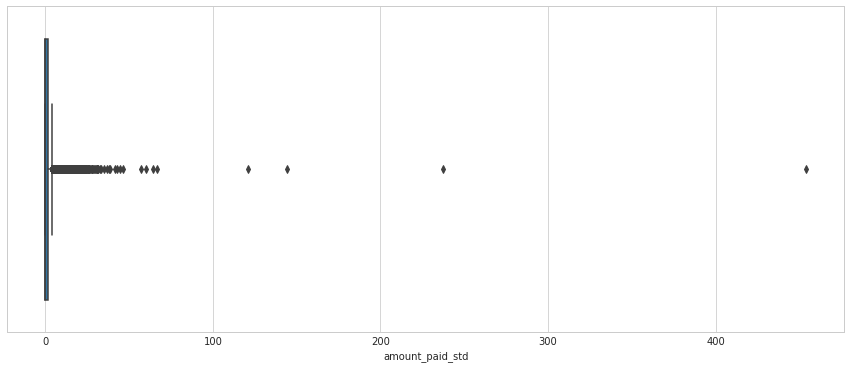

Column : amount_paid_quantile75, Mean : 11.298, Median : 10.222, Std : 6.196


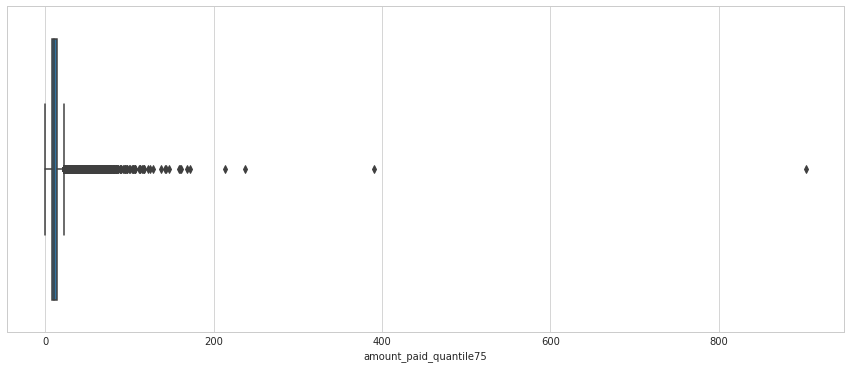

Column : payment_id_1491_num, Mean : 0.149, Median : 0.000, Std : 1.548


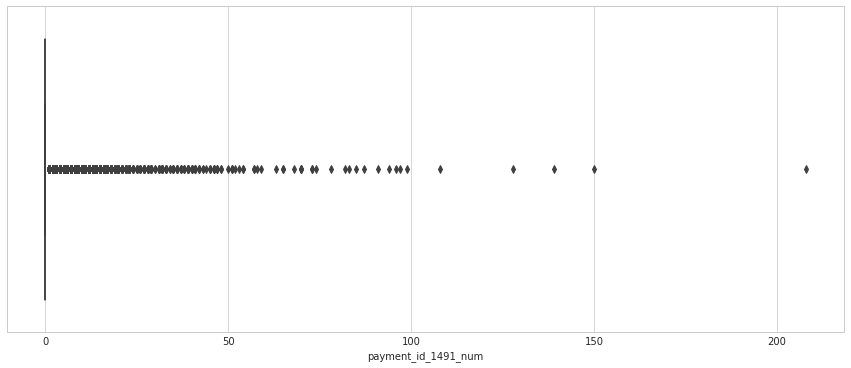

Column : payment_id_1523_num, Mean : 0.020, Median : 0.000, Std : 0.754


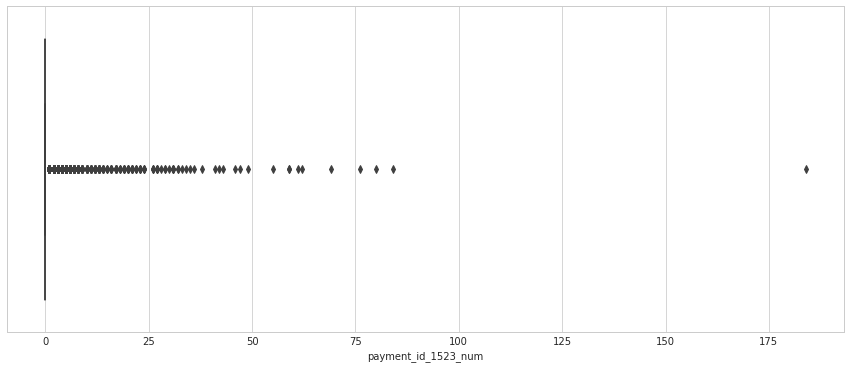

Column : payment_id_1619_num, Mean : 1.942, Median : 1.000, Std : 4.652


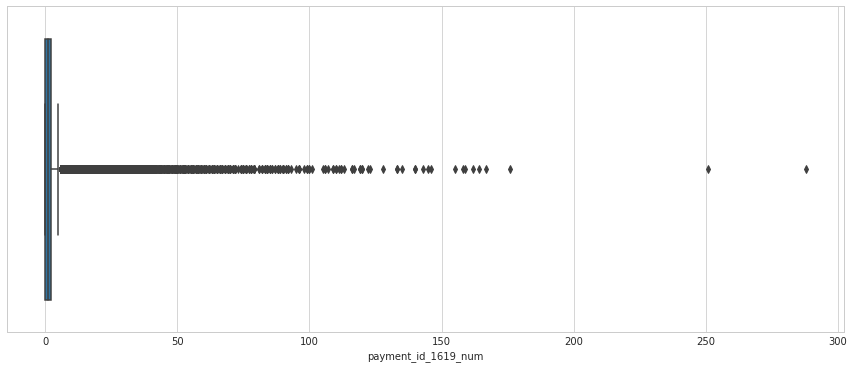

Column : payment_id_1779_num, Mean : 0.954, Median : 0.000, Std : 3.803


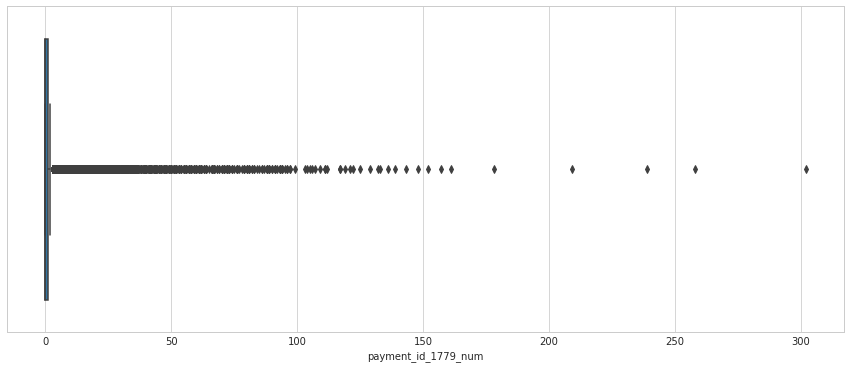

Column : payment_id_1811_num, Mean : 0.141, Median : 0.000, Std : 1.282


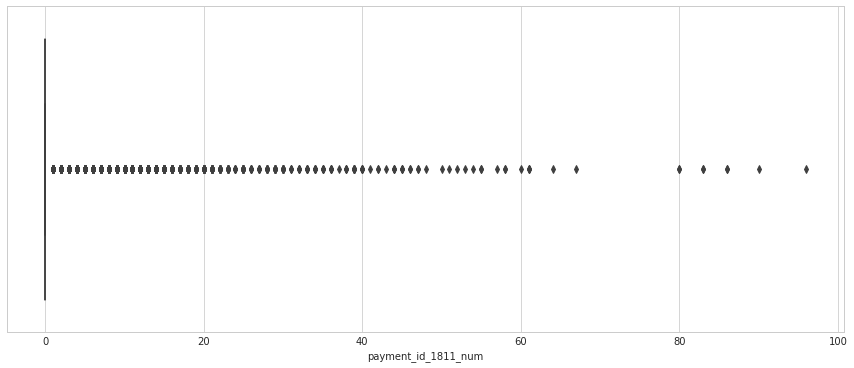

Column : platform_id_525_num, Mean : 0.004, Median : 0.000, Std : 0.073


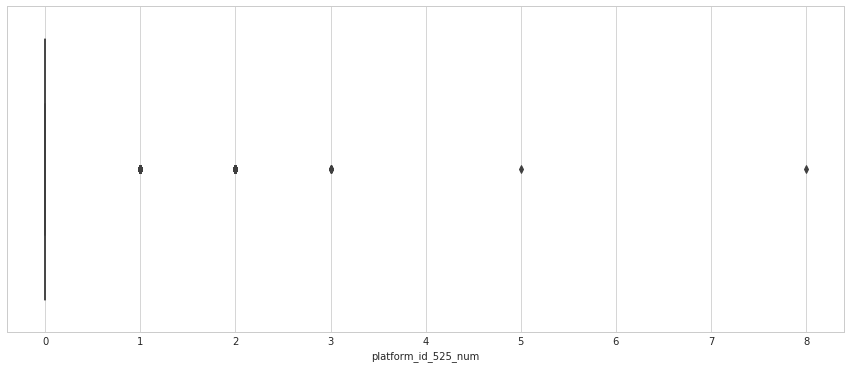

Column : platform_id_22167_num, Mean : 0.000, Median : 0.000, Std : 0.003


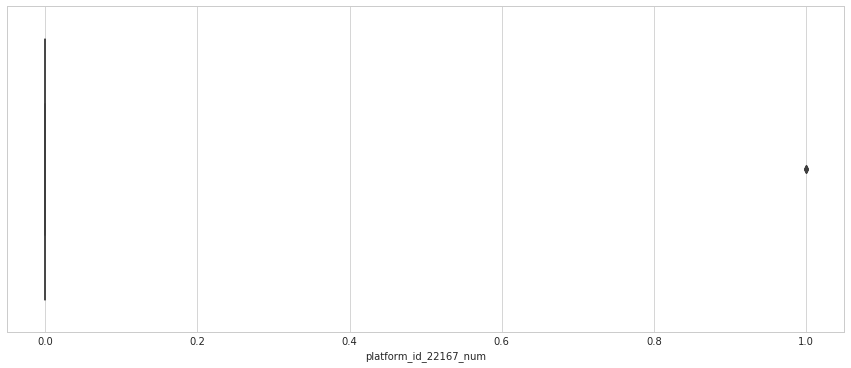

Column : platform_id_22263_num, Mean : 0.001, Median : 0.000, Std : 0.073


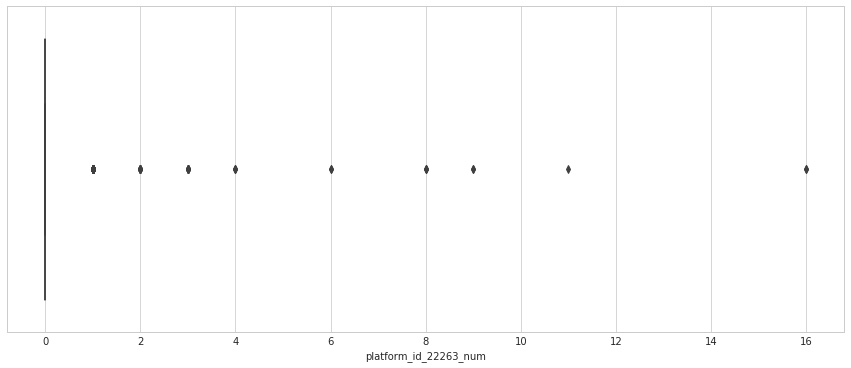

Column : platform_id_22295_num, Mean : 0.000, Median : 0.000, Std : 0.002


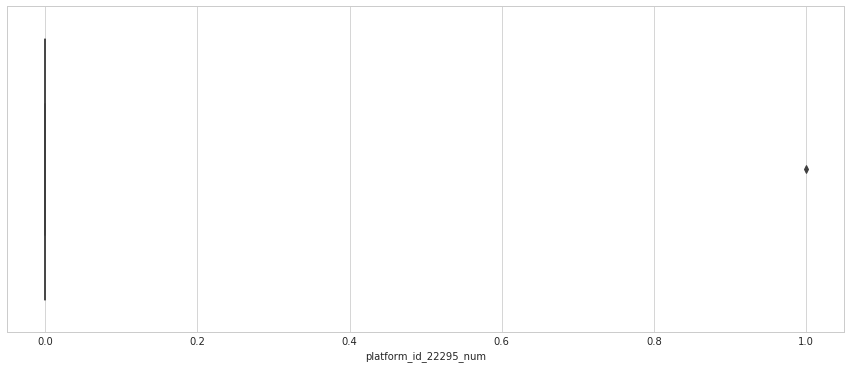

Column : platform_id_29463_num, Mean : 0.984, Median : 0.000, Std : 3.787


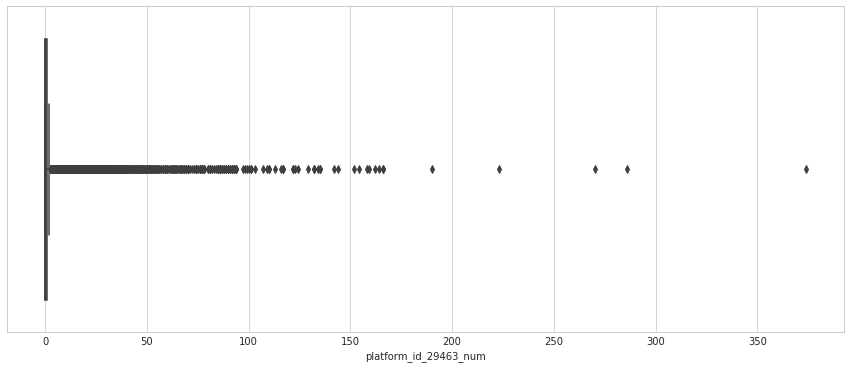

Column : platform_id_29495_num, Mean : 0.045, Median : 0.000, Std : 0.375


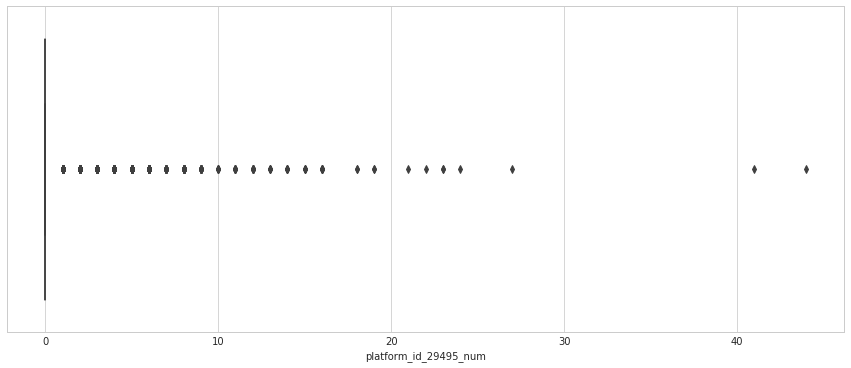

Column : platform_id_29751_num, Mean : 0.079, Median : 0.000, Std : 1.221


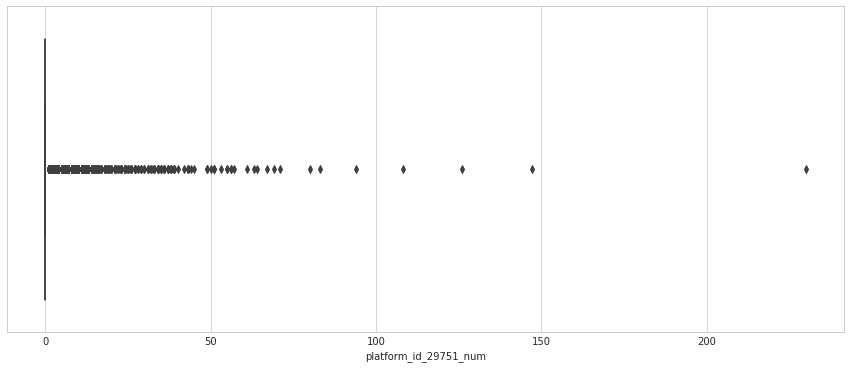

Column : platform_id_29815_num, Mean : 0.648, Median : 0.000, Std : 3.341


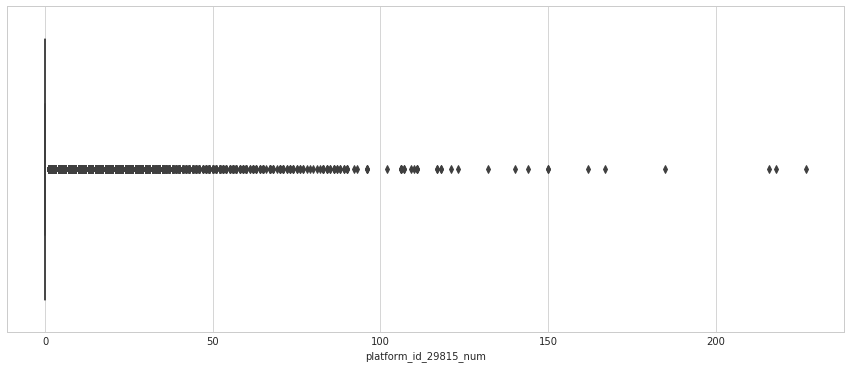

Column : platform_id_30135_num, Mean : 0.002, Median : 0.000, Std : 0.225


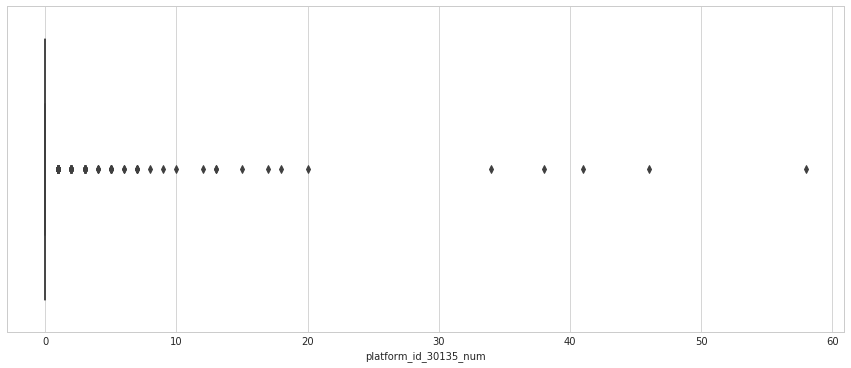

Column : platform_id_30199_num, Mean : 0.008, Median : 0.000, Std : 0.324


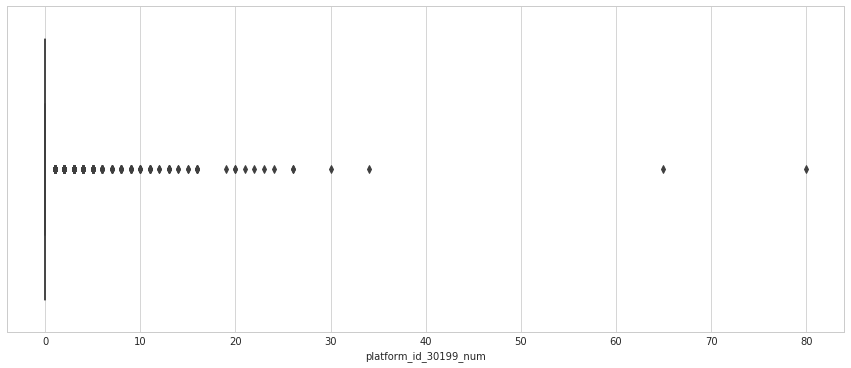

Column : platform_id_30231_num, Mean : 0.883, Median : 0.000, Std : 4.027


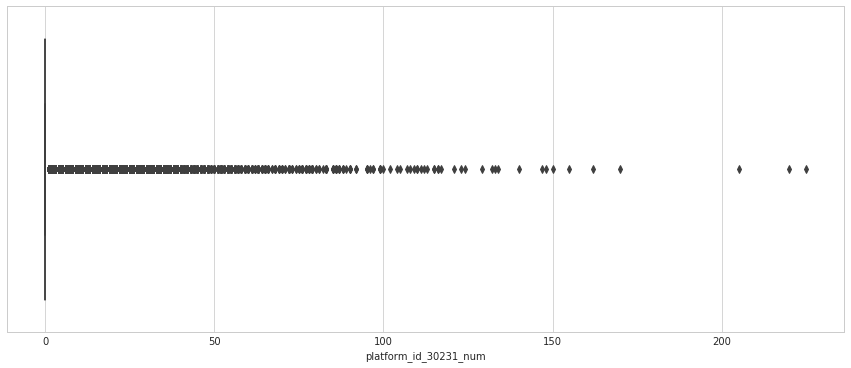

Column : platform_id_30359_num, Mean : 0.422, Median : 0.000, Std : 1.648


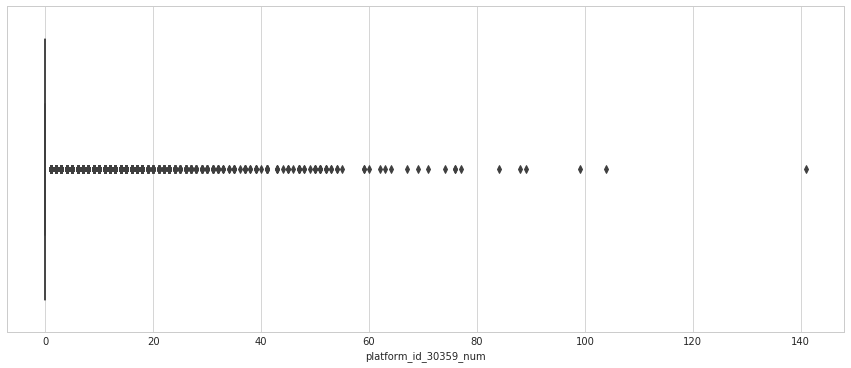

Column : platform_id_30391_num, Mean : 0.100, Median : 0.000, Std : 0.576


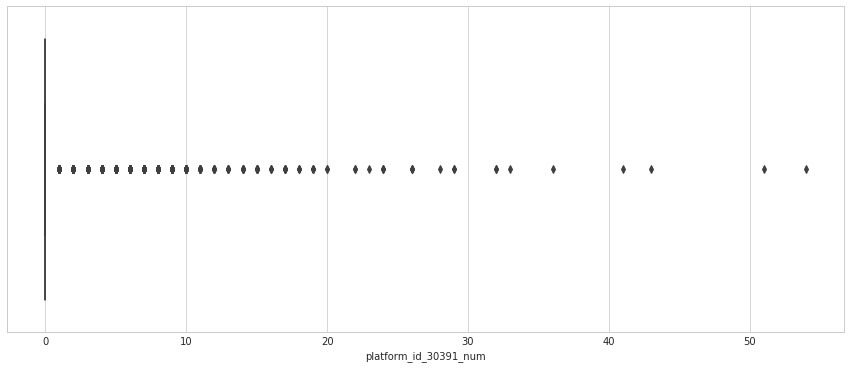

Column : platform_id_30423_num, Mean : 0.028, Median : 0.000, Std : 0.263


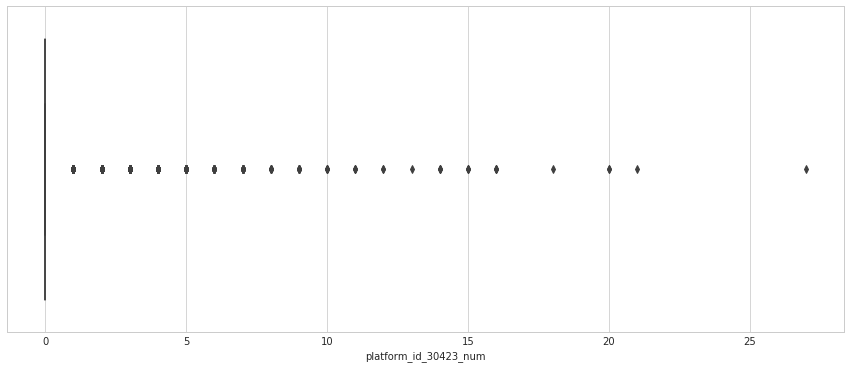

Column : transmission_id_212_num, Mean : 0.052, Median : 0.000, Std : 0.538


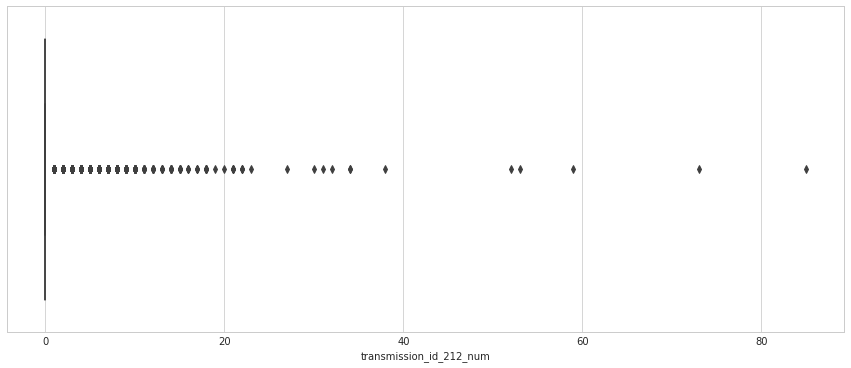

Column : transmission_id_1988_num, Mean : 0.001, Median : 0.000, Std : 0.033


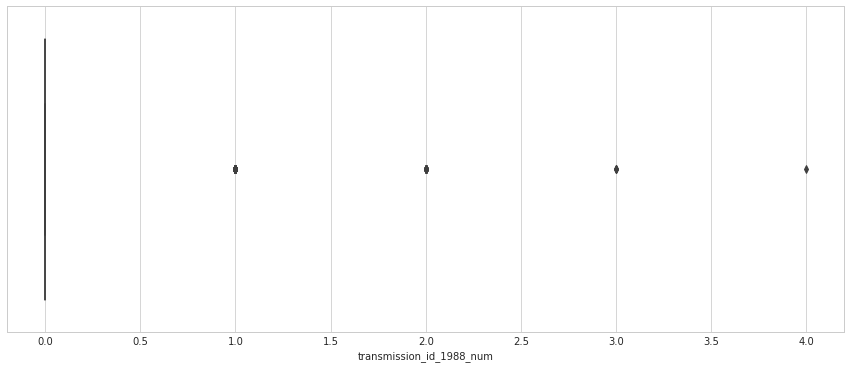

Column : transmission_id_2020_num, Mean : 0.000, Median : 0.000, Std : 0.002


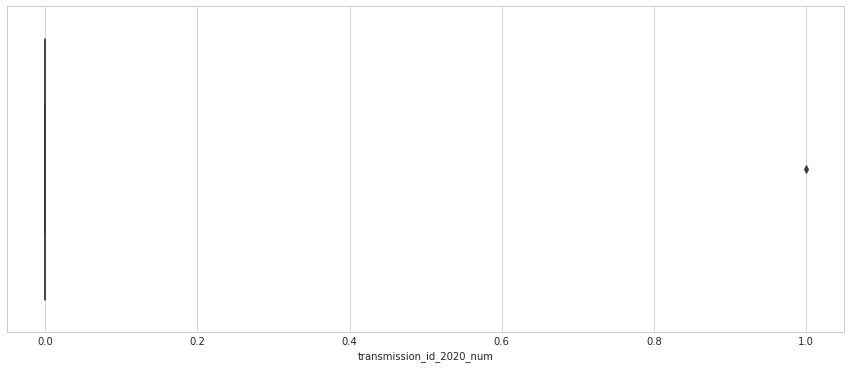

Column : transmission_id_4196_num, Mean : 0.021, Median : 0.000, Std : 0.321


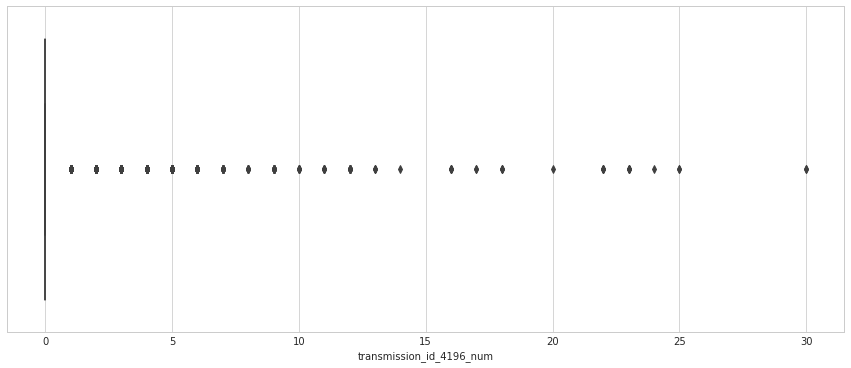

Column : transmission_id_4228_num, Mean : 0.821, Median : 0.000, Std : 2.780


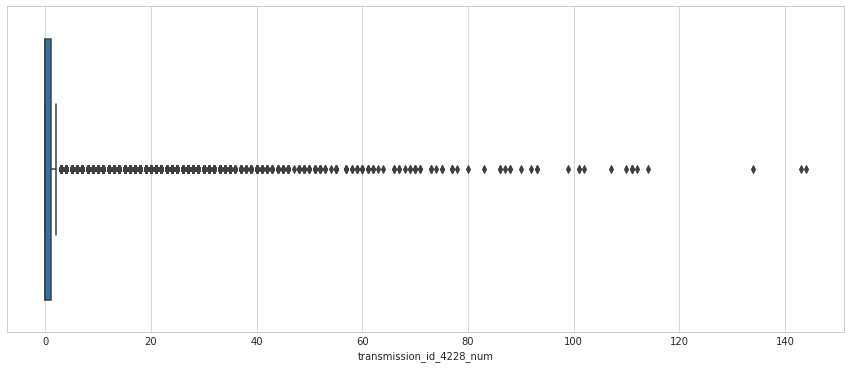

Column : transmission_id_4260_num, Mean : 0.059, Median : 0.000, Std : 0.518


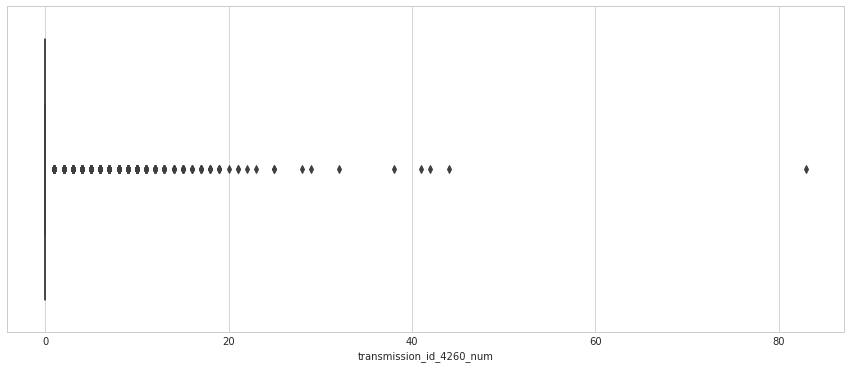

Column : transmission_id_4324_num, Mean : 0.830, Median : 0.000, Std : 2.507


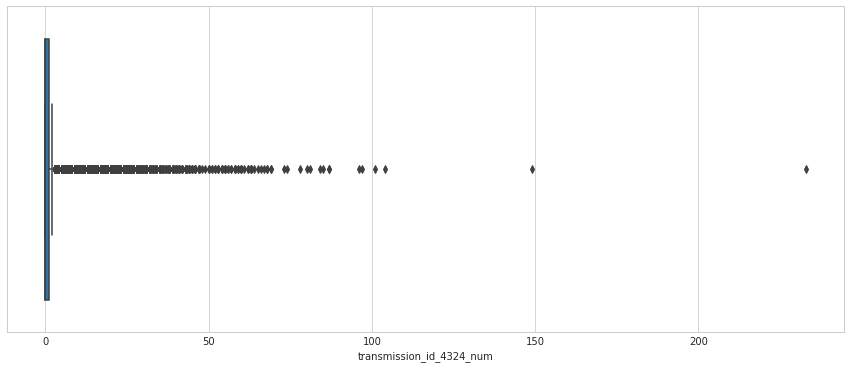

Column : transmission_id_4356_num, Mean : 1.392, Median : 1.000, Std : 3.922


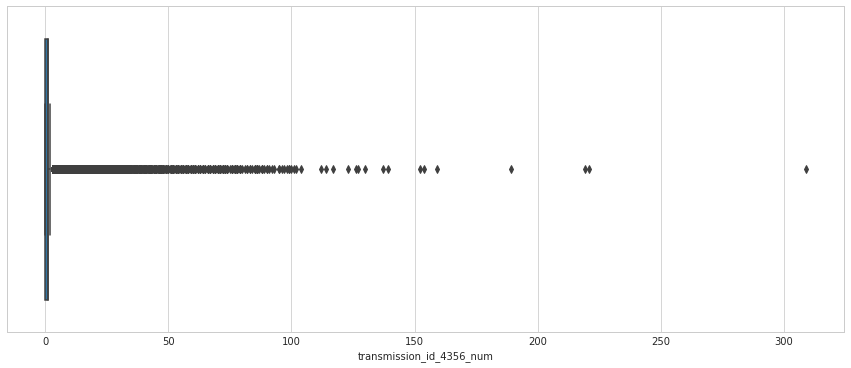

Column : transmission_id_4996_num, Mean : 0.027, Median : 0.000, Std : 0.265


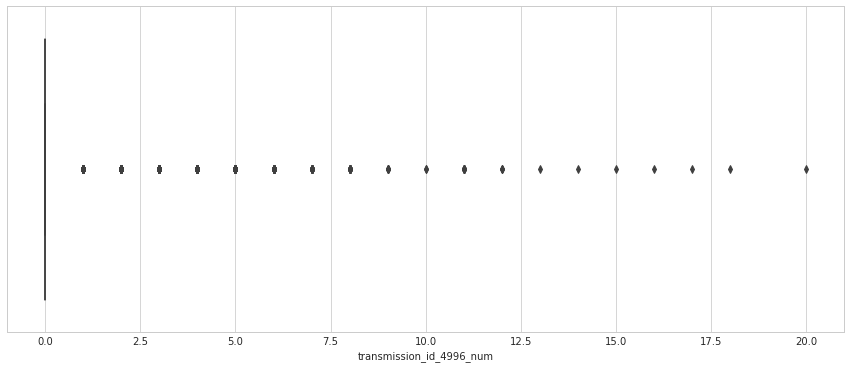

Column : transmission_id_21124_num, Mean : 0.001, Median : 0.000, Std : 0.028


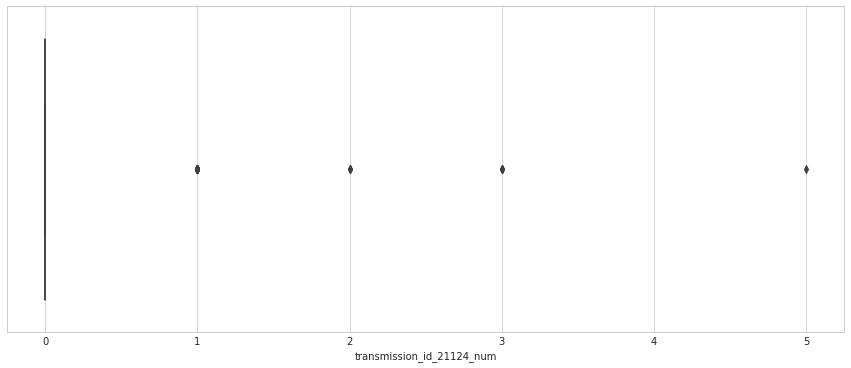

In [5]:
# Check outliers
sns.set_style("whitegrid")
for col in orders_per_client.columns.tolist()[1:]:
    print('Column : {}, Mean : {:.3f}, Median : {:.3f}, Std : {:.3f}'.format(col, 
                                                               orders_per_client[col].mean(), 
                                                               orders_per_client[col].median(),
                                                               orders_per_client[col].std()))
    plt.figure(figsize=(15,6))
    sns.boxplot(x=orders_per_client[col])
    plt.show()

In [130]:
# # Remove outliers: mean +- 2sigma
# for col in orders_per_client.columns[1:]:
#     mean = np.mean(orders_per_client[col])
#     std = np.std(orders_per_client[col])
#     rows_before = orders_per_client.shape[0]
#     orders_per_client = orders_per_client[(orders_per_client[col] >= mean - 3 * std) &\
#                                           (orders_per_client[col] <= mean + 3 * std)]
#     rows_after = orders_per_client.shape[0]
#     print('Column : {}. Rows removed : {:d}. Mean={:.3f}, Std={:.3f}'.format(
#         col, rows_before - rows_after, mean, std))

Column : orders_num. Rows removed : 3994. Mean=3.205, Std=7.026
Column : is_failed_num. Rows removed : 2585. Mean=0.075, Std=0.381
Column : voucher_amount_sum. Rows removed : 3313. Mean=0.238, Std=1.201
Column : delivery_fee_mean. Rows removed : 4193. Mean=0.189, Std=0.356
Column : delivery_fee_sum. Rows removed : 4093. Mean=0.406, Std=1.107
Column : delivery_fee_num. Rows removed : 3422. Mean=0.428, Std=0.864
Column : restaurant_id_unq_num. Rows removed : 6730. Mean=1.508, Std=1.140
Column : city_id_unq_num. Rows removed : 5454. Mean=1.027, Std=0.171
Column : payment_id_unq_num. Rows removed : 1121. Mean=1.097, Std=0.315
Column : platform_id_unq_num. Rows removed : 2913. Mean=1.129, Std=0.382
Column : transmission_id_unq_num. Rows removed : 5100. Mean=1.194, Std=0.459
Column : amount_paid_mean. Rows removed : 3022. Mean=10.870, Std=5.775
Column : amount_paid_sum. Rows removed : 3597. Mean=17.113, Std=18.107
Column : amount_paid_std. Rows removed : 4717. Mean=0.574, Std=1.361
Column : 

In [106]:
# Correlations
# Create correlation matrix
corr_matrix = orders_per_client.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(to_drop)

['delivery_fee_num', 'amount_paid_sum', 'amount_paid_quantile75']


In [107]:
orders_per_client.shape

(245455, 45)

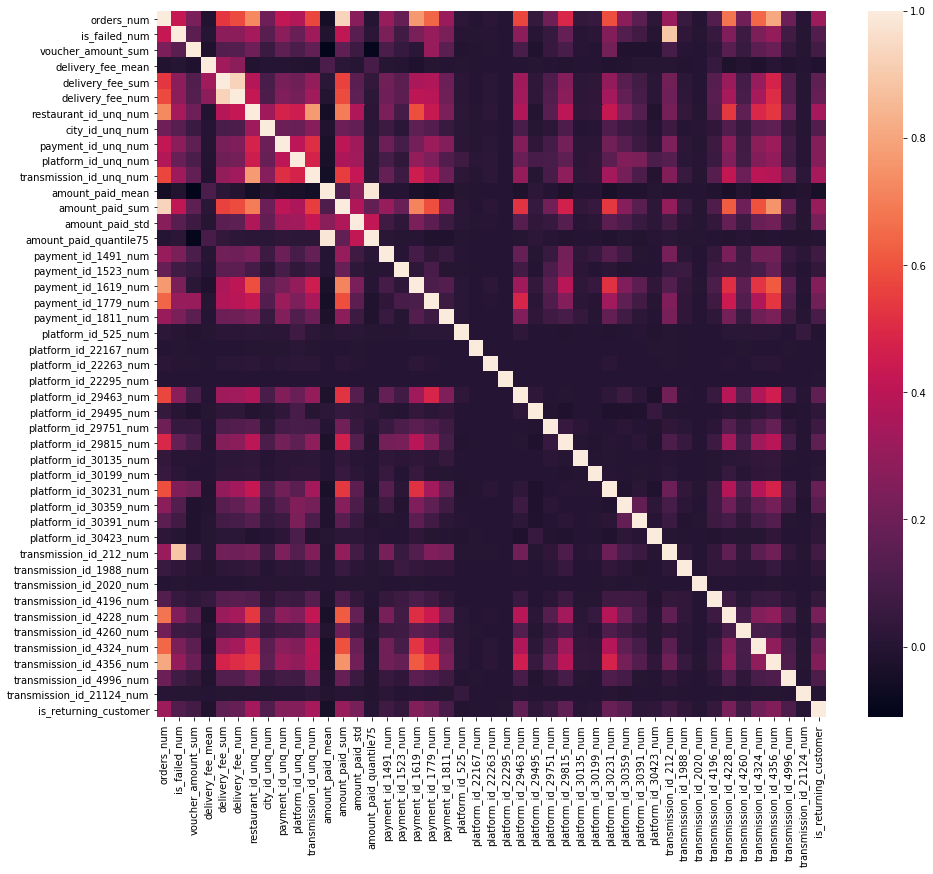

In [108]:
corr = orders_per_client.merge(labeled_data, on='customer_id', how='left', validate='one_to_one').corr()
plt.figure(figsize=(15,13))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

In [109]:
orders_per_client.drop(to_drop, axis=1, inplace=True)

In [110]:
orders_per_client.shape

(245455, 42)

In [111]:
# Take only these for sequence learning 
orders_per_client[orders_per_client['orders_num'] > 1].shape

(99957, 42)

### Create training data

In [112]:
order_train = orders_per_client.merge(labeled_data, on='customer_id', how='left', validate='one_to_one')

In [13]:
order_train.shape

(245455, 46)

In [14]:
order_train.head()

,customer_id,orders_num,is_failed_num,voucher_amount_sum,delivery_fee_mean,delivery_fee_sum,delivery_fee_num,restaurant_id_unq_num,city_id_unq_num,payment_id_unq_num,platform_id_unq_num,transmission_id_unq_num,amount_paid_mean,amount_paid_sum,amount_paid_std,amount_paid_quantile75,payment_id_1491_num,payment_id_1523_num,payment_id_1619_num,payment_id_1779_num,payment_id_1811_num,platform_id_525_num,platform_id_22167_num,platform_id_22263_num,platform_id_22295_num,platform_id_29463_num,platform_id_29495_num,platform_id_29751_num,platform_id_29815_num,platform_id_30135_num,platform_id_30199_num,platform_id_30231_num,platform_id_30359_num,platform_id_30391_num,platform_id_30423_num,transmission_id_212_num,transmission_id_1988_num,transmission_id_2020_num,transmission_id_4196_num,transmission_id_4228_num,transmission_id_4260_num,transmission_id_4324_num,transmission_id_4356_num,transmission_id_4996_num,transmission_id_21124_num,is_returning_customer
0,000097eabfd9,1,0,0.0,0.000,0.000,0,1,1,1,1,1,11.46960,11.46960,0.0,11.46960,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0000e2c6d9be,1,0,0.0,0.000,0.000,0,1,1,1,1,1,9.55800,9.55800,0.0,9.55800,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2,000133bb597f,1,0,0.0,0.493,0.493,1,1,1,1,1,1,5.93658,5.93658,0.0,5.93658,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
3,00018269939b,1,0,0.0,0.493,0.493,1,1,1,1,1,1,9.82350,9.82350,0.0,9.82350,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0001a00468a6,1,0,0.0,0.493,0.493,1,1,1,1,1,1,5.15070,5.15070,0.0,5.15070,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [15]:
order_train.isna().sum(axis=0)

customer_id                  0
orders_num                   0
is_failed_num                0
voucher_amount_sum           0
delivery_fee_mean            0
delivery_fee_sum             0
delivery_fee_num             0
restaurant_id_unq_num        0
city_id_unq_num              0
payment_id_unq_num           0
platform_id_unq_num          0
transmission_id_unq_num      0
amount_paid_mean             0
amount_paid_sum              0
amount_paid_std              0
amount_paid_quantile75       0
payment_id_1491_num          0
payment_id_1523_num          0
payment_id_1619_num          0
payment_id_1779_num          0
payment_id_1811_num          0
platform_id_525_num          0
platform_id_22167_num        0
platform_id_22263_num        0
platform_id_22295_num        0
platform_id_29463_num        0
platform_id_29495_num        0
platform_id_29751_num        0
platform_id_29815_num        0
platform_id_30135_num        0
platform_id_30199_num        0
platform_id_30231_num        0
platform

In [16]:
order_train['is_returning_customer'].value_counts() / order_train.shape[0]

0    0.773861
1    0.226139
Name: is_returning_customer, dtype: float64

In [15]:
order_train = order_train[tree_important_features.tolist() + ['is_returning_customer']]

NameError: name 'tree_important_features' is not defined

In [ ]:
order_train.head()

In [113]:
X = order_train.iloc[:, 1:-1]
y = order_train.iloc[:, -1]

In [114]:
# Normalize table
scaler = preprocessing.StandardScaler().fit(X)
scaler_file = 'scaler.pkl'
pickle.dump(scaler, open(scaler_file, 'wb'))
X_norm = scaler.transform(X)
# df[columns_norm] = df[columns_norm].astype('float32')

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.3, stratify=y, 
                                                    shuffle=True, random_state=142) 
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.1, stratify=y_test, 
                                                shuffle=True, random_state=142) 

In [19]:
y_train.mean(), y_val.mean(), y_test.mean(), len(y_train), len(y_val), len(y_test)

(0.22614045094227614,
 0.22614035881882516,
 0.22609994568169473,
 171818,
 66273,
 7364)

In [35]:
# def compute_metrics(X, y, model, threshold=0.5, to_print=True, to_return=False,
#                     compute_acc=True, compute_auc=True, compute_aps=True):
#     if compute_acc:
#         acc = accuracy_score(y, (model.predict_proba(X)[:,1] > threshold).astype('int'))
#     if compute_auc:
#         auc = roc_auc_score(y, model.predict_proba(X)[:,1])
#     if compute_aps:
#         aps = average_precision_score(y, model.predict_proba(X)[:,1])
#     if to_print:
#         print('acc = {:.3f}, auc = {:.3f}, aps = {:.3f}'.format(acc if compute_acc else np.nan, 
#                                                                 auc if compute_auc else np.nan, 
#                                                                 aps if compute_aps else np.nan))
#     if to_return:
#         return acc, auc, aps

In [20]:
def compute_metrics(y_true, y_pred, prob):
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, prob)
    aps = average_precision_score(y_true, prob)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return {'acc': acc, 'auc': auc, 'aps': aps, 
            'precision': precision, 'recall': recall, 
            'f1': f1}

In [21]:
def compute_basic_metrics(y_true, y_pred, prob):
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, prob)
    aps = average_precision_score(y_true, prob)
    
    return {'acc': acc, 'auc': auc, 'aps': aps}

In [22]:
def try_acc_thresholds(model, data_dict):
    thresholds = [.1,.2,.3,.4,.5,.6,.7,.8,.9]
    for thr in thresholds:
        acc_train = accuracy_score(data_dict['y_train'], 
                                   (model.predict_proba(data_dict['X_train'])[:,1] > thr).astype('int'))
        acc_val = accuracy_score(data_dict['y_val'], 
                                 (model.predict_proba(data_dict['X_val'])[:,1] > thr).astype('int'))
        print('Threshold= {}, Train acc= {:.3f},  Val acc= {:.3f}'.format(thr, acc_train, acc_val))

In [23]:
def compute_zero_baseline(y_true):
    metric_dict = compute_basic_metrics(y_true, np.zeros(y_true.shape[0]), np.zeros(y_true.shape[0]))
    return metric_dict

In [24]:
def compute_rand_baseline(y_true, thr=0.5):
    rand_pred = np.random.random_sample((y_true.shape[0],))
    metric_dict = compute_metrics(y_true, np.round(rand_pred + 0.5 - thr), rand_pred)
    return metric_dict

## Baseline

In [25]:
# Baseline on train: zero prediction
compute_zero_baseline(y_train)

{'acc': 0.77385954905772392, 'auc': 0.5, 'aps': 0.22614045094227614}

In [26]:
# Baseline on train: random prediction with thr=0.5
compute_rand_baseline(y_train, thr=0.5)

{'acc': 0.50166455202598093,
 'auc': 0.49902688741915818,
 'aps': 0.22540208355054861,
 'precision': 0.22651571856287425,
 'recall': 0.49846866555140906,
 'f1': 0.3114852966009698}

In [27]:
# Baseline on train: random prediction with thr=0.9
compute_rand_baseline(y_train, thr=0.9)

{'acc': 0.71883621040868828,
 'auc': 0.49983634918525133,
 'aps': 0.22591723023333327,
 'precision': 0.2247262986256697,
 'recall': 0.09931797709432505,
 'f1': 0.13775501097685044}

In [28]:
# Baseline on val: zero prediction
compute_zero_baseline(y_val)

{'acc': 0.77385964118117478, 'auc': 0.5, 'aps': 0.22614035881882516}

In [29]:
# Baseline on val: random prediction with thr=0.5
compute_rand_baseline(y_val, thr=0.5)

{'acc': 0.49979629713457968,
 'auc': 0.49895146944039614,
 'aps': 0.22480537945599074,
 'precision': 0.22617216945575155,
 'recall': 0.5005004337092146,
 'f1': 0.31155507559395246}

In [30]:
# Baseline on val: random prediction with thr=0.9
compute_rand_baseline(y_val, thr=0.9)

{'acc': 0.71950869886680846,
 'auc': 0.49780329578931493,
 'aps': 0.22545030671614247,
 'precision': 0.2266241651487553,
 'recall': 0.099619670380996866,
 'f1': 0.13840092699884124}

## Logistic regression

In [77]:
log_reg = LogisticRegression(C=1.0)
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [78]:
y_pred_val = log_reg.predict_proba(X_val)[:,1]

In [40]:
log_reg.coef_, log_reg.intercept_

(array([[ 0.16651498, -0.12283527, -0.01029817, -0.00572569, -0.02866383,
          0.03792088,  0.01761649,  0.08840141,  0.13637122,  0.20663683,
         -0.13702842,  0.23211777, -0.05207465,  0.03483228,  0.11228627,
          0.17283153,  0.03484056, -0.05823805, -0.00107428, -0.01566295,
          0.00268848,  0.0680445 ,  0.01673157,  0.05492044,  0.09360992,
         -0.00235683, -0.00824459,  0.07772015,  0.18853922, -0.16383915,
          0.0203705 ,  0.01479835,  0.04545471,  0.0130741 , -0.01853944,
          0.1367761 ,  0.00093357,  0.01565219,  0.17770433,  0.18727632,
         -0.01018647]]), array([-1.33196033]))

In [41]:
prob_train = log_reg.predict_proba(X_train)[:,1]
y_pred_train = log_reg.predict(X_train)
prob_val = log_reg.predict_proba(X_val)[:,1]
y_pred_val = log_reg.predict(X_val)

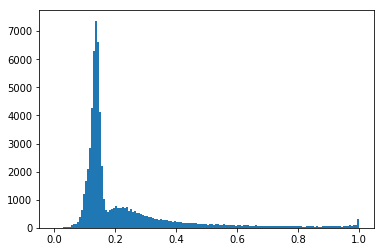

In [42]:
plt.hist(prob_val, bins=150)
plt.show()

In [43]:
compute_metrics(y_train, y_pred_train, prob_train)

{'acc': 0.80886752261113504,
 'auc': 0.75145655076534978,
 'aps': 0.54329459842311734,
 'precision': 0.7092173913043478,
 'recall': 0.26238579333419121,
 'f1': 0.38305466842006386}

In [44]:
compute_metrics(y_val, y_pred_val, prob_val)

{'acc': 0.80773467324551473,
 'auc': 0.75378283688263292,
 'aps': 0.5432924488044707,
 'precision': 0.70005346640527533,
 'recall': 0.26209381463935411,
 'f1': 0.38139625206330713}

In [72]:
# Try thresholds on thain set
data_dict = {'X_train': X_train, 'y_train': y_train,
             'X_val': X_val, 'y_val': y_val}
try_acc_thresholds(log_reg, data_dict)

Threshold= 0.1, Train acc= 0.260,  Val acc= 0.260
Threshold= 0.2, Train acc= 0.737,  Val acc= 0.736
Threshold= 0.3, Train acc= 0.794,  Val acc= 0.793
Threshold= 0.4, Train acc= 0.808,  Val acc= 0.807
Threshold= 0.5, Train acc= 0.809,  Val acc= 0.808
Threshold= 0.6, Train acc= 0.805,  Val acc= 0.804
Threshold= 0.7, Train acc= 0.799,  Val acc= 0.799
Threshold= 0.8, Train acc= 0.794,  Val acc= 0.794
Threshold= 0.9, Train acc= 0.788,  Val acc= 0.787


## Random forests

In [91]:
tree_clf = RandomForestClassifier(n_estimators=50, max_depth=4)

In [92]:
tree_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [94]:
prob_train = tree_clf.predict_proba(X_train)[:,1]
y_pred_train = tree_clf.predict(X_train)
prob_val = tree_clf.predict_proba(X_val)[:,1]
y_pred_val = tree_clf.predict(X_val)

In [95]:
compute_metrics(y_train, y_pred_train, prob_train)

{'acc': 0.80982784108766248,
 'auc': 0.75826272831172292,
 'aps': 0.54117772359595406,
 'precision': 0.6884376143432126,
 'recall': 0.29054175781752672,
 'f1': 0.40862939568892187}

In [96]:
compute_metrics(y_val, y_pred_val, prob_val)

{'acc': 0.80974152369743335,
 'auc': 0.76009353695325621,
 'aps': 0.5416553703105238,
 'precision': 0.68514481469947053,
 'recall': 0.29358777607259623,
 'f1': 0.41104208510439533}

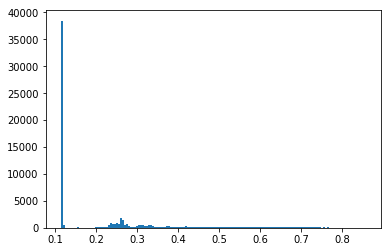

In [98]:
plt.hist(prob_val, bins=150)
plt.show()

In [121]:
# Try thresholds
try_acc_thresholds(tree_clf, data_dict)

Threshold= 0.1, Train= 0.226,  Val= 0.226
Threshold= 0.2, Train= 0.695,  Val= 0.694
Threshold= 0.3, Train= 0.778,  Val= 0.779
Threshold= 0.4, Train= 0.806,  Val= 0.805
Threshold= 0.5, Train= 0.810,  Val= 0.810
Threshold= 0.6, Train= 0.800,  Val= 0.799
Threshold= 0.7, Train= 0.786,  Val= 0.785
Threshold= 0.8, Train= 0.775,  Val= 0.775
Threshold= 0.9, Train= 0.774,  Val= 0.774


In [99]:
tree_clf_2 = RandomForestClassifier(n_estimators=10, max_depth=20)

In [100]:
tree_clf_2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [101]:
compute_metrics(y_train, y_pred_train, prob_train)

{'acc': 0.80982784108766248,
 'auc': 0.75826272831172292,
 'aps': 0.54117772359595406,
 'precision': 0.6884376143432126,
 'recall': 0.29054175781752672,
 'f1': 0.40862939568892187}

In [102]:
compute_metrics(y_val, y_pred_val, prob_val) # why no overfit?

{'acc': 0.80974152369743335,
 'auc': 0.76009353695325621,
 'aps': 0.5416553703105238,
 'precision': 0.68514481469947053,
 'recall': 0.29358777607259623,
 'f1': 0.41104208510439533}

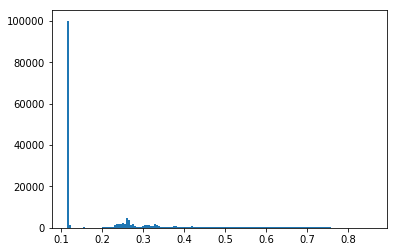

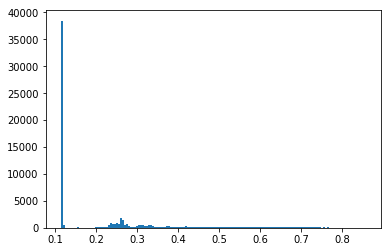

In [103]:
plt.hist(prob_train, bins=150)
plt.show()
plt.hist(prob_val, bins=150)
plt.show()

## Decision tree

In [25]:
dtree_clf = tree.DecisionTreeClassifier()
dtree_clf = dtree_clf.fit(X_train, y_train)

In [26]:
prob_train = dtree_clf.predict_proba(X_train)[:,1]
y_pred_train = dtree_clf.predict(X_train)
prob_val = dtree_clf.predict_proba(X_val)[:,1]
y_pred_val = dtree_clf.predict(X_val)

In [27]:
compute_metrics(y_train, y_pred_train, prob_train)

{'acc': 0.96072588436601525,
 'auc': 0.9886546668212034,
 'aps': 0.96903076615064454,
 'precision': 0.99644370226056844,
 'recall': 0.82928837987389015,
 'f1': 0.90521406899651646}

In [28]:
compute_metrics(y_val, y_pred_val, prob_val)

{'acc': 0.75092420744496247,
 'auc': 0.59328944123761274,
 'aps': 0.32288884248669358,
 'precision': 0.44228432563791009,
 'recall': 0.38860345632881832,
 'f1': 0.41370982063576633}

In [29]:
dtree_clf.get_params()

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

In [45]:
# Let's try to avoid overfitting

In [58]:
dtree_clf = tree.DecisionTreeClassifier(max_depth=6)
dtree_clf = dtree_clf.fit(X_train, y_train)

In [59]:
prob_train = dtree_clf.predict_proba(X_train)[:,1]
y_pred_train = dtree_clf.predict(X_train)
prob_val = dtree_clf.predict_proba(X_val)[:,1]
y_pred_val = dtree_clf.predict(X_val)

In [60]:
compute_metrics(y_train, y_pred_train, prob_train)

{'acc': 0.81433260775937333,
 'auc': 0.76020631782320114,
 'aps': 0.53463298125040937,
 'precision': 0.67883962555292665,
 'recall': 0.33967314373954444,
 'f1': 0.45278487743794704}

In [61]:
compute_metrics(y_val, y_pred_val, prob_val)

{'acc': 0.8122010471836193,
 'auc': 0.75914105474624438,
 'aps': 0.5313676176028459,
 'precision': 0.66821130676552365,
 'recall': 0.33675852405418027,
 'f1': 0.44782608695652176}

## SVM with kernel rbf

In [ ]:
gamma = 10
for i in range(3):
    svm_clf = svm.SVC(kernel='rbf', gamma=gamma)
    svm_clf.fit(X_train, y_train)
    
    prob_train = svm_clf.predict_proba(X_train)[:,1]
    y_pred_train = svm_clf.predict(X_train)
    prob_val = svm_clf.predict_proba(X_val)[:,1]
    y_pred_val = svm_clf.predict(X_val)

    scores_train = compute_metrics(y_train, y_pred_train, prob_train)
    scores_val = compute_metrics(y_val, y_pred_val, prob_val)
    print('Gamma= {}\nTrain scores:\n{},\nVal scores:\n{}'.format(gamma, scores_train, scores_val))
    gamma /= 10 

## XGboost

In [95]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [96]:
prob_train = xgb_model.predict_proba(X_train)[:,1]
y_pred_train = xgb_model.predict(X_train)
prob_val = xgb_model.predict_proba(X_val)[:,1]
y_pred_val = xgb_model.predict(X_val)

In [97]:
compute_metrics(y_train, y_pred_train, prob_train)

{'acc': 0.816037900569207,
 'auc': 0.77000277229598579,
 'aps': 0.57244115145606378,
 'precision': 0.6899407663678776,
 'recall': 0.33874662205636341,
 'f1': 0.45439480770558593}

In [98]:
compute_metrics(y_val, y_pred_val, prob_val)

{'acc': 0.81447950145609826,
 'auc': 0.76982824207502987,
 'aps': 0.56856870553164895,
 'precision': 0.68071965628356601,
 'recall': 0.33829318742910525,
 'f1': 0.45197236460887008}

In [352]:
# compute_metrics(X_val, y_val, xgb_model)

acc = 0.814, auc = 0.770, aps = 0.569


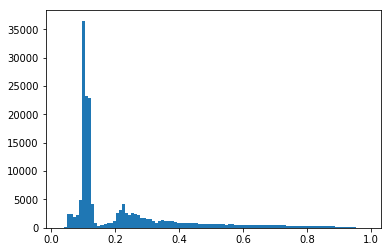

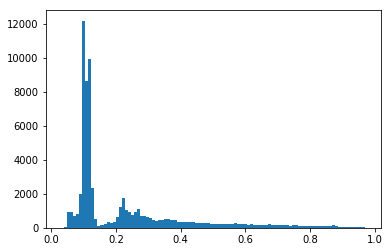

In [354]:
plt.hist(xgb_model.predict_proba(X_train)[:,1], bins=100)
plt.show()
plt.hist(xgb_model.predict_proba(X_val)[:,1], bins=100)
plt.show()

In [122]:
# Try thresholds
try_acc_thresholds(tree_clf, data_dict)

Threshold= 0.1, Train= 0.226,  Val= 0.226
Threshold= 0.2, Train= 0.695,  Val= 0.694
Threshold= 0.3, Train= 0.778,  Val= 0.779
Threshold= 0.4, Train= 0.806,  Val= 0.805
Threshold= 0.5, Train= 0.810,  Val= 0.810
Threshold= 0.6, Train= 0.800,  Val= 0.799
Threshold= 0.7, Train= 0.786,  Val= 0.785
Threshold= 0.8, Train= 0.775,  Val= 0.775
Threshold= 0.9, Train= 0.774,  Val= 0.774


## Feature importances

In [123]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [124]:
def get_feature_importances(model, feature_names):
    feature_importance_values = model.feature_importances_
    feature_importances = pd.DataFrame({'feature': feature_names, 
                                        'importance': feature_importance_values})
    return feature_importances

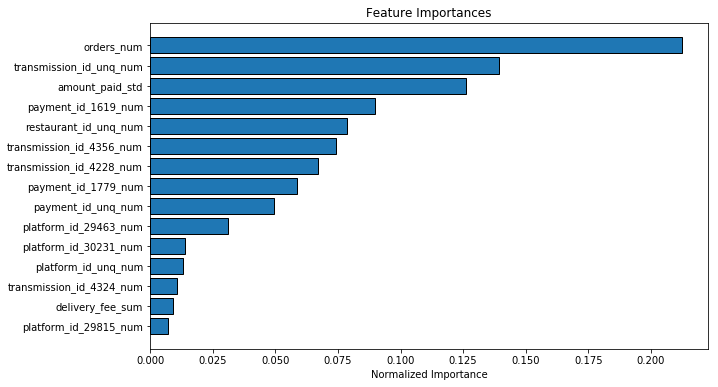

In [125]:
# Forest
fi = get_feature_importances(tree_clf, X.columns)
tree_df_fi = plot_feature_importances(fi)

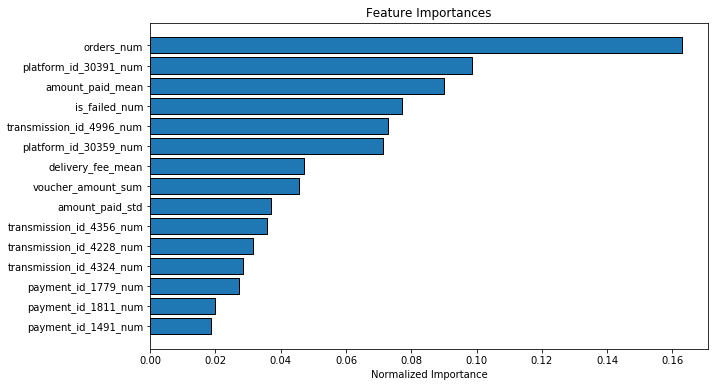

In [126]:
# XGB
fi = get_feature_importances(xgb_model, X.columns)
xgb_df_fi = plot_feature_importances(fi)

In [127]:
tree_important_features = tree_df_fi[tree_df_fi['importance'] >= 0.01]['feature']
tree_important_features

0                   orders_num
1      transmission_id_unq_num
2              amount_paid_std
3          payment_id_1619_num
4        restaurant_id_unq_num
5     transmission_id_4356_num
6     transmission_id_4228_num
7          payment_id_1779_num
8           payment_id_unq_num
9        platform_id_29463_num
10       platform_id_30231_num
11         platform_id_unq_num
12    transmission_id_4324_num
Name: feature, dtype: object

In [128]:
xgb_important_features = xgb_df_fi[xgb_df_fi['importance'] >= 0.01]['feature']
xgb_important_features

0                   orders_num
1        platform_id_30391_num
2             amount_paid_mean
3                is_failed_num
4     transmission_id_4996_num
5        platform_id_30359_num
6            delivery_fee_mean
7           voucher_amount_sum
8              amount_paid_std
9     transmission_id_4356_num
10    transmission_id_4228_num
11    transmission_id_4324_num
12         payment_id_1779_num
13         payment_id_1811_num
14         payment_id_1491_num
15    transmission_id_1988_num
16         platform_id_525_num
17         payment_id_1619_num
18       platform_id_30231_num
19       platform_id_29815_num
20         platform_id_unq_num
21       restaurant_id_unq_num
Name: feature, dtype: object

## Ensemble

In [90]:
class EnsembleModel():
    def __init__(self, model_list, weights=None):
        self.model_list = model_list
        if not weights:
            self.weights = [1./len(model_list)] * len(model_list)
        else:
            self.weights = weights
        # check sum of weight =1
        if sum(self.weights) != 1.:
            print('Error. Weights sum is not 1')
    
    def predict_proba(self, X):
        outputs = np.vstack([model.predict_proba(X)[:,1] for model in self.model_list])
        return np.average(outputs, axis=0, weights=self.weights)
    
    def predict(self, X):
        outputs = np.vstack([model.predict(X) for model in self.model_list])
        return np.round(np.average(outputs, axis=0, weights=self.weights))

In [105]:
log_reg = LogisticRegression(C=1.0)
log_reg.fit(X_train, y_train)

dtree_clf = tree.DecisionTreeClassifier(max_depth=6)
dtree_clf = dtree_clf.fit(X_train, y_train)

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

ensemble = EnsembleModel([log_reg, dtree_clf, xgb_model])#, weights=[0.1, 0.3, 0.6])

In [106]:
prob_train = ensemble.predict_proba(X_train)
y_pred_train = ensemble.predict(X_train)
prob_val = ensemble.predict_proba(X_val)
y_pred_val = ensemble.predict(X_val)

In [103]:
compute_metrics(y_train, y_pred_train, prob_train)

{'acc': 0.81556647149891159,
 'auc': 0.76870600907042086,
 'aps': 0.56961515864641887,
 'precision': 0.69688976810638537,
 'recall': 0.3263929996139493,
 'f1': 0.44456908488598323}

In [94]:
compute_metrics(y_val, y_pred_val, prob_val)

{'acc': 0.81416263033211111,
 'auc': 0.76809796401665598,
 'aps': 0.56404911351097098,
 'precision': 0.68644422727907306,
 'recall': 0.32808433976112633,
 'f1': 0.44397291196388267}

## MLP in Keras

In [35]:
import os
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF

def get_session(gpu_fraction=0.2):
    '''Assume that you have 6GB of GPU memory and want to allocate ~2GB'''

    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)

    if num_threads:
        return tf.Session(config=tf.ConfigProto(
            gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

KTF.set_session(get_session())

In [38]:
from keras.models import Sequential
from keras.layers import Dense
from keras import metrics
from keras import optimizers
from keras.callbacks import ModelCheckpoint

In [41]:
# Create model
model = Sequential()
model.add(Dense(128, input_dim=41, kernel_initializer='uniform', activation='relu'))
model.add(Dense(32, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
# Optimizer
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# Compile model
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
# Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
# Fit the model
model.fit(X_train, y_train, epochs=150, batch_size=64, callbacks=callbacks_list, 
          verbose=2, validation_data=(X_val, y_val))

Train on 171818 samples, validate on 66273 samples
Epoch 1/150
 - 9s - loss: 0.4571 - acc: 0.8068 - val_loss: 0.4430 - val_acc: 0.8114

Epoch 00001: val_acc improved from -inf to 0.81137, saving model to weights.best.hdf5
Epoch 2/150
 - 9s - loss: 0.4421 - acc: 0.8126 - val_loss: 0.4404 - val_acc: 0.8121

Epoch 00002: val_acc improved from 0.81137 to 0.81213, saving model to weights.best.hdf5
Epoch 3/150
 - 9s - loss: 0.4408 - acc: 0.8129 - val_loss: 0.4402 - val_acc: 0.8123

Epoch 00003: val_acc improved from 0.81213 to 0.81234, saving model to weights.best.hdf5
Epoch 4/150
 - 9s - loss: 0.4402 - acc: 0.8131 - val_loss: 0.4394 - val_acc: 0.8126

Epoch 00004: val_acc improved from 0.81234 to 0.81261, saving model to weights.best.hdf5
Epoch 5/150
 - 10s - loss: 0.4398 - acc: 0.8134 - val_loss: 0.4397 - val_acc: 0.8123

Epoch 00005: val_acc did not improve from 0.81261
Epoch 6/150
 - 9s - loss: 0.4393 - acc: 0.8134 - val_loss: 0.4394 - val_acc: 0.8118

Epoch 00006: val_acc did not improv

 - 9s - loss: 0.4291 - acc: 0.8201 - val_loss: 0.4429 - val_acc: 0.8123

Epoch 00059: val_acc did not improve from 0.81410
Epoch 60/150
 - 9s - loss: 0.4287 - acc: 0.8205 - val_loss: 0.4425 - val_acc: 0.8109

Epoch 00060: val_acc did not improve from 0.81410
Epoch 61/150
 - 9s - loss: 0.4287 - acc: 0.8201 - val_loss: 0.4422 - val_acc: 0.8123

Epoch 00061: val_acc did not improve from 0.81410
Epoch 62/150
 - 9s - loss: 0.4284 - acc: 0.8209 - val_loss: 0.4436 - val_acc: 0.8117

Epoch 00062: val_acc did not improve from 0.81410
Epoch 63/150
 - 9s - loss: 0.4283 - acc: 0.8213 - val_loss: 0.4434 - val_acc: 0.8119

Epoch 00063: val_acc did not improve from 0.81410
Epoch 64/150
 - 9s - loss: 0.4281 - acc: 0.8207 - val_loss: 0.4447 - val_acc: 0.8109

Epoch 00064: val_acc did not improve from 0.81410
Epoch 65/150
 - 9s - loss: 0.4283 - acc: 0.8211 - val_loss: 0.4439 - val_acc: 0.8110

Epoch 00065: val_acc did not improve from 0.81410
Epoch 66/150
 - 9s - loss: 0.4278 - acc: 0.8214 - val_loss: 0


Epoch 00119: val_acc did not improve from 0.81410
Epoch 120/150
 - 9s - loss: 0.4181 - acc: 0.8276 - val_loss: 0.4578 - val_acc: 0.8062

Epoch 00120: val_acc did not improve from 0.81410
Epoch 121/150
 - 9s - loss: 0.4182 - acc: 0.8278 - val_loss: 0.4582 - val_acc: 0.8086

Epoch 00121: val_acc did not improve from 0.81410
Epoch 122/150
 - 9s - loss: 0.4180 - acc: 0.8274 - val_loss: 0.4571 - val_acc: 0.8071

Epoch 00122: val_acc did not improve from 0.81410
Epoch 123/150
 - 9s - loss: 0.4176 - acc: 0.8271 - val_loss: 0.4587 - val_acc: 0.8071

Epoch 00123: val_acc did not improve from 0.81410
Epoch 124/150
 - 9s - loss: 0.4178 - acc: 0.8272 - val_loss: 0.4586 - val_acc: 0.8086

Epoch 00124: val_acc did not improve from 0.81410
Epoch 125/150
 - 9s - loss: 0.4179 - acc: 0.8278 - val_loss: 0.4609 - val_acc: 0.8082

Epoch 00125: val_acc did not improve from 0.81410
Epoch 126/150
 - 9s - loss: 0.4174 - acc: 0.8277 - val_loss: 0.4601 - val_acc: 0.8064

Epoch 00126: val_acc did not improve fro

In [42]:
# Restore the best epoch
model.load_weights("weights.best.hdf5")

In [47]:
# estimate accuracy on whole dataset using loaded weights
scores_train = model.evaluate(X_train, y_train, verbose=0)
scores_val = model.evaluate(X_val, y_val, verbose=0)
scores_train, scores_val

([0.43224539596081241, 0.81855218894480908],
 [0.43913647790596522, 0.81410227392754209])

In [48]:
# calculate predictions
prob_train = model.predict(X_train)
y_pred_train = [round(x[0]) for x in prob_train]
prob_val = model.predict(X_val)
y_pred_val = [round(x[0]) for x in prob_val]

In [49]:
compute_metrics(y_train, y_pred_train, prob_train)

{'acc': 0.8185521889441153,
 'auc': 0.77283312265600745,
 'aps': 0.58342185763903809,
 'precision': 0.70829490587533228,
 'recall': 0.33601853043366364,
 'f1': 0.45580226225387521}

In [50]:
compute_metrics(y_val, y_pred_val, prob_val)

{'acc': 0.81410227392754209,
 'auc': 0.7682259337286117,
 'aps': 0.56266923708458993,
 'precision': 0.68482328482328481,
 'recall': 0.32968572763061321,
 'f1': 0.44509503648319976}

In [51]:
# Create model. Learning rate changed
model = Sequential()
model.add(Dense(128, input_dim=41, kernel_initializer='uniform', activation='relu'))
model.add(Dense(32, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
# Optimizer
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
# Compile model
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
# Checkpoint
filepath="weights.best_lr.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
# Fit the model
model.fit(X_train, y_train, epochs=150, batch_size=64, callbacks=callbacks_list, 
          verbose=2, validation_data=(X_val, y_val))

Train on 171818 samples, validate on 66273 samples
Epoch 1/150
 - 9s - loss: 0.5284 - acc: 0.7782 - val_loss: 0.4641 - val_acc: 0.8013

Epoch 00001: val_acc improved from -inf to 0.80126, saving model to weights.best.hdf5
Epoch 2/150
 - 9s - loss: 0.4545 - acc: 0.8070 - val_loss: 0.4485 - val_acc: 0.8091

Epoch 00002: val_acc improved from 0.80126 to 0.80912, saving model to weights.best.hdf5
Epoch 3/150
 - 9s - loss: 0.4475 - acc: 0.8107 - val_loss: 0.4453 - val_acc: 0.8109

Epoch 00003: val_acc improved from 0.80912 to 0.81086, saving model to weights.best.hdf5
Epoch 4/150
 - 9s - loss: 0.4452 - acc: 0.8115 - val_loss: 0.4439 - val_acc: 0.8114

Epoch 00004: val_acc improved from 0.81086 to 0.81136, saving model to weights.best.hdf5
Epoch 5/150
 - 9s - loss: 0.4440 - acc: 0.8124 - val_loss: 0.4431 - val_acc: 0.8119

Epoch 00005: val_acc improved from 0.81136 to 0.81190, saving model to weights.best.hdf5
Epoch 6/150
 - 9s - loss: 0.4431 - acc: 0.8124 - val_loss: 0.4423 - val_acc: 0.811

 - 9s - loss: 0.4356 - acc: 0.8158 - val_loss: 0.4395 - val_acc: 0.8132

Epoch 00057: val_acc improved from 0.81300 to 0.81323, saving model to weights.best.hdf5
Epoch 58/150
 - 9s - loss: 0.4355 - acc: 0.8160 - val_loss: 0.4391 - val_acc: 0.8128

Epoch 00058: val_acc did not improve from 0.81323
Epoch 59/150
 - 9s - loss: 0.4354 - acc: 0.8159 - val_loss: 0.4386 - val_acc: 0.8129

Epoch 00059: val_acc did not improve from 0.81323
Epoch 60/150
 - 10s - loss: 0.4353 - acc: 0.8159 - val_loss: 0.4391 - val_acc: 0.8127

Epoch 00060: val_acc did not improve from 0.81323
Epoch 61/150
 - 9s - loss: 0.4353 - acc: 0.8164 - val_loss: 0.4389 - val_acc: 0.8128

Epoch 00061: val_acc did not improve from 0.81323
Epoch 62/150
 - 9s - loss: 0.4352 - acc: 0.8166 - val_loss: 0.4394 - val_acc: 0.8125

Epoch 00062: val_acc did not improve from 0.81323
Epoch 63/150
 - 9s - loss: 0.4351 - acc: 0.8162 - val_loss: 0.4387 - val_acc: 0.8133

Epoch 00063: val_acc improved from 0.81323 to 0.81335, saving model to 


Epoch 00116: val_acc did not improve from 0.81335
Epoch 117/150
 - 9s - loss: 0.4318 - acc: 0.8184 - val_loss: 0.4410 - val_acc: 0.8130

Epoch 00117: val_acc did not improve from 0.81335
Epoch 118/150
 - 9s - loss: 0.4319 - acc: 0.8188 - val_loss: 0.4411 - val_acc: 0.8129

Epoch 00118: val_acc did not improve from 0.81335
Epoch 119/150
 - 9s - loss: 0.4319 - acc: 0.8185 - val_loss: 0.4404 - val_acc: 0.8120

Epoch 00119: val_acc did not improve from 0.81335
Epoch 120/150
 - 10s - loss: 0.4317 - acc: 0.8186 - val_loss: 0.4407 - val_acc: 0.8127

Epoch 00120: val_acc did not improve from 0.81335
Epoch 121/150
 - 10s - loss: 0.4316 - acc: 0.8186 - val_loss: 0.4404 - val_acc: 0.8129

Epoch 00121: val_acc did not improve from 0.81335
Epoch 122/150
 - 9s - loss: 0.4316 - acc: 0.8189 - val_loss: 0.4406 - val_acc: 0.8128

Epoch 00122: val_acc did not improve from 0.81335
Epoch 123/150
 - 9s - loss: 0.4316 - acc: 0.8190 - val_loss: 0.4403 - val_acc: 0.8131

Epoch 00123: val_acc did not improve f

In [52]:
# Restore the best epoch
model.load_weights("weights.best.hdf5")

In [53]:
# estimate accuracy on whole dataset using loaded weights
scores_train = model.evaluate(X_train, y_train, verbose=0)
scores_val = model.evaluate(X_val, y_val, verbose=0)
scores_train, scores_val

([0.43443416632712495, 0.81657917098186206],
 [0.43867087720272763, 0.81334781887042984])

In [54]:
# calculate predictions
prob_train = model.predict(X_train)
y_pred_train = [round(x[0]) for x in prob_train]
prob_val = model.predict(X_val)
y_pred_val = [round(x[0]) for x in prob_val]

In [55]:
compute_metrics(y_train, y_pred_train, prob_train)

{'acc': 0.81657917098324972,
 'auc': 0.77083898523903582,
 'aps': 0.57446706508628254,
 'precision': 0.68741701562659585,
 'recall': 0.34644189936945052,
 'f1': 0.46070126803223982}

In [56]:
compute_metrics(y_val, y_pred_val, prob_val)

{'acc': 0.81334781887042984,
 'auc': 0.76802947923193399,
 'aps': 0.56233226927030877,
 'precision': 0.67053303792519225,
 'recall': 0.34329752452125173,
 'f1': 0.4541041482789055}

## Sequences in tensorflow

In [ ]:
from bunch import Bunch

In [135]:
order_data_lbl = order_data.merge(labeled_data, on='customer_id', how='left', validate='many_to_one')

In [136]:
order_data_lbl.shape

(786600, 42)

In [137]:
order_data_lbl.columns

Index(['customer_id', 'order_hour', 'customer_order_rank', 'is_failed',
       'voucher_amount', 'delivery_fee', 'amount_paid', 'restaurant_id',
       'city_id', 'payment_id', 'platform_id', 'transmission_id',
       'payment_id_1491', 'payment_id_1523', 'payment_id_1619',
       'payment_id_1779', 'payment_id_1811', 'platform_id_525',
       'platform_id_22167', 'platform_id_22263', 'platform_id_22295',
       'platform_id_29463', 'platform_id_29495', 'platform_id_29751',
       'platform_id_29815', 'platform_id_30135', 'platform_id_30199',
       'platform_id_30231', 'platform_id_30359', 'platform_id_30391',
       'platform_id_30423', 'transmission_id_212', 'transmission_id_1988',
       'transmission_id_2020', 'transmission_id_4196', 'transmission_id_4228',
       'transmission_id_4260', 'transmission_id_4324', 'transmission_id_4356',
       'transmission_id_4996', 'transmission_id_21124',
       'is_returning_customer'],
      dtype='object')

In [191]:
order_data_lbl.drop(['order_date', 'customer_order_rank', 'restaurant_id',
                     'restaurant_id', 'city_id', 'payment_id', 'platform_id',
                     'transmission_id'], axis=1, inplace=True)

In [187]:
labeled_data.shape, len(pd.unique(order_data_lbl['customer_id']))

((245455, 2), 245455)

In [192]:
order_data_lbl.head(1)

,customer_id,order_hour,is_failed,voucher_amount,delivery_fee,amount_paid,payment_id_1491,payment_id_1523,payment_id_1619,payment_id_1779,payment_id_1811,platform_id_525,platform_id_22167,platform_id_22263,platform_id_22295,platform_id_29463,platform_id_29495,platform_id_29751,platform_id_29815,platform_id_30135,platform_id_30199,platform_id_30231,platform_id_30359,platform_id_30391,platform_id_30423,transmission_id_212,transmission_id_1988,transmission_id_2020,transmission_id_4196,transmission_id_4228,transmission_id_4260,transmission_id_4324,transmission_id_4356,transmission_id_4996,transmission_id_21124,is_returning_customer
0,000097eabfd9,19,0,0.0,0.0,11.4696,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [193]:
cust_train, cust_val, lbl_train, lbl_val = train_test_split(labeled_data, labeled_data['is_returning_customer'], 
                                                            test_size=0.3, stratify=labeled_data['is_returning_customer'],
                                                            shuffle=True, random_state=142)
lbl_train.mean(), lbl_val.mean(), len(lbl_train), len(lbl_val)

(0.22614045094227614, 0.22613631734046744, 171818, 73637)

In [139]:
import tensorflow as tf


def set_seed(config):
    np.random.seed(config.seed)
    random.seed(config.seed)
    
    
def set_gpu_config(gpu_frac):
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_frac, allow_growth=True)
    gpu_config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options) #True
    
    return gpu_config

In [313]:
config = {'batch_size': 64, 'num_epochs': 1, 'input_size': 39, 'seed': 142,
          'gpu_frac': 0.5, 'threshold': 0.5, 'learning_rate': 1e-3, 'num_rnn_layers': 2,
          'hid_size': 32}
config = Bunch(config)

In [294]:
DATA_VARIABLES = 'data_variables'


def init_data_variables(sess):
    for data_var in tf.get_collection(DATA_VARIABLES):
        data_var.init(sess)


class DataVarWrapper:
    def __init__(self, data):
        self.name = 'data_wrapper'
        self.data = data
        self.var = tf.Variable(tf.zeros(self.data.shape, dtype=self.data.dtype), 
                               validate_shape=False, trainable=False, 
                               dtype=self.data.dtype, collections=[], name='data_var')
        tf.add_to_collection(DATA_VARIABLES, self)

        
    def init(self, sess):
        self.var.load(self.data, sess)

In [307]:
class BatchIterator:
    def __init__(self, config, order_data):
        self.config = config
        
        with tf.device('/cpu:0'):
            self.data_var_wrapper = DataVarWrapper(order_data.values.astype('float32'))
            
            
    def _map_function(self, row):
        sample_dict = {
            'X': self.data_var_wrapper.var[row[0]:row[0]+row[1], :],
            'y': row[2],
            'seqlen': row[1] 
        }
        return sample_dict
    
    
    def create_iterator(self, sess, order_summary, is_training=True):
        if is_training:
            dataset = tf.data.Dataset.from_tensor_slices(order_summary)
            dataset = dataset.shuffle(10000)
            dataset = dataset.repeat(self.config.num_epochs)
        else:
            dataset = tf.data.Dataset.from_tensor_slices(order_summary)

        dataset = dataset.map(self._map_function, num_parallel_calls=64)
        dataset = dataset.padded_batch(self.config.batch_size, 
                                       padded_shapes={'X': [None, self.config.input_size],
                                                      'y': [],
                                                      'seqlen': []})            
        dataset = dataset.prefetch(4)
        init_iter = dataset.make_initializable_iterator()
        get_next = init_iter.get_next()

        return {'init_iter': init_iter.initializer, 'get_next': get_next}

In [159]:
def create_order_summary(order_data_lbl):
#     customer_ids = pd.unique(labeled_data['customer_id'])
    grouped = order_data_lbl.groupby('customer_id', as_index=False)
    order_summary_list = []
    
    for name, group in grouped:
        #orders = order_data[order_data['customer_id'] == customer_id]
        order_summary_list.append([name, group.index[0], group.shape[0], 
                                   (group['is_returning_customer'].sum() > 0).astype('int8')])
            
    order_summary = np.array(order_summary_list)
    order_summary = pd.DataFrame(order_summary, columns=['customer_id', 'idx_start', 'num_orders', 'label'])
    
    order_summary['customer_id'] = order_summary['customer_id'].astype('str')
    order_summary['idx_start'] = order_summary['idx_start'].astype('int64')
    order_summary['num_orders'] = order_summary['num_orders'].astype('int64')
    order_summary['label'] = order_summary['label'].astype('int8')
    
    return order_summary

In [213]:
order_summary = create_order_summary(order_data_lbl)

In [214]:
order_summary.head(1)

,customer_id,idx_start,num_orders,label
0,000097eabfd9,0,1,0


In [215]:
order_summary_train = order_summary[order_summary['customer_id'].isin(cust_train['customer_id'])]
order_summary_val = order_summary[order_summary['customer_id'].isin(cust_val['customer_id'])]
order_summary_train.shape, order_summary_val.shape

((171818, 4), (73637, 4))

In [314]:
tf.reset_default_graph()
gpu_config = set_gpu_config(config.gpu_frac)
sess = tf.Session(config=gpu_config)

In [315]:
batch_iterator = BatchIterator(config, order_data_lbl.iloc[:, 1:-1])
iter_dict = {'train': batch_iterator.create_iterator(sess, order_summary_train.iloc[:, 1:], True),
             'val': batch_iterator.create_iterator(sess, order_summary_val.iloc[:, 1:], False)}

In [298]:
iter_dict['train'], iter_dict['val']

({'init_iter': <tf.Operation 'MakeIterator' type=MakeIterator>,
  'get_next': {'X': <tf.Tensor 'IteratorGetNext:0' shape=(?, ?, 39) dtype=float32>,
   'y': <tf.Tensor 'IteratorGetNext:2' shape=(?,) dtype=int64>,
   'seqlen': <tf.Tensor 'IteratorGetNext:1' shape=(?,) dtype=int64>}},
 {'init_iter': <tf.Operation 'MakeIterator_1' type=MakeIterator>,
  'get_next': {'X': <tf.Tensor 'IteratorGetNext_1:0' shape=(?, ?, 39) dtype=float32>,
   'y': <tf.Tensor 'IteratorGetNext_1:2' shape=(?,) dtype=int64>,
   'seqlen': <tf.Tensor 'IteratorGetNext_1:1' shape=(?,) dtype=int64>}})

In [299]:
sess.run(tf.global_variables_initializer(), init_data_variables(sess))
sess.run(iter_dict['train']['init_iter'])

In [300]:
next_batch = sess.run(iter_dict['train']['get_next'])
next_batch['X'].shape, next_batch['y'].shape, next_batch['seqlen'].max()

((64, 22, 39), (64,), 22)

In [301]:
def network(data_dict, config):
    cell = tf.contrib.cudnn_rnn.CudnnLSTM(num_layers=config.num_rnn_layers,
                                          num_units=config.hid_size,  
                                          kernel_initializer=tf.initializers.random_normal(stddev=1e-3),
                                          bias_initializer=tf.initializers.zeros())
    cell.build(input_shape=data_dict['input'].shape)
    outputs, output_states = cell.call(inputs=data_dict['input'])
    
#     conv1 = causal_conv1d(outputs, 
#                           filters=config.num_filters,
#                           kernel_size=config.filter_width,  
#                           kernel_initializer=tf.initializers.random_normal(stddev=1e-3),
#                           bias_initializer=tf.initializers.ones(), 
#                           #padding='same', 
#                           activation=tf.nn.relu)
#     conv2 = causal_conv1d(conv1, 
#                           filters=config.num_filters,
#                           kernel_size=config.filter_width,  
#                           kernel_initializer=tf.initializers.random_normal(stddev=1e-3),
#                           bias_initializer=tf.initializers.ones(), 
#                           #padding='same', 
#                           activation=tf.nn.relu)
    dense = tf.layers.dense(inputs=outputs, 
                            units=1, 
                            activation=tf.nn.sigmoid, 
                            kernel_initializer=tf.initializers.random_normal(stddev=1e-3),
                            bias_initializer=tf.initializers.ones())
    return dense

In [302]:
class Model:
    def __init__(self, config):
        self.config = config
        self.build_model()
        
        
    def build_model(self):
        # data placeholders
        self.data_dict = {'input': tf.placeholder(tf.float32, shape=[None, None, self.config.input_size]), 
                          'target': tf.placeholder(tf.float32, shape=[None]), 
                          'seq_lens': tf.placeholder(tf.int64, shape=[None])}
        # training parameters
        self.threshold = tf.placeholder_with_default(self.config.threshold, shape=[])
        self.learning_rate = tf.placeholder_with_default(self.config.learning_rate, shape=[])
        
        self.max_len = tf.reduce_max(self.data_dict['seq_lens'])
        self.mask = tf.sequence_mask(self.data_dict['seq_lens'], self.max_len)
        net_output = network(self.data_dict, self.config)
        self.dense = self.extract_axis_1(net_output, self.data_dict['seq_lens'] - 1)
        
        with tf.name_scope('predicted_probs'):
            self.prediction = tf.squeeze(self.dense, axis=1)
        with tf.name_scope('rounded_predictions'):
            self.prediction_int = tf.round(tf.add(self.prediction, 0.5-self.config.threshold))
        with tf.name_scope('is_correct_predictions'):
            self.is_correct_pred = self._is_correct_pred(self.data_dict['target'], 
                                                         self.prediction_int)
            
        with tf.name_scope('loss'):
            self.loss = self._cost(self.data_dict['target'], self.prediction)
        with tf.name_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(self.config.learning_rate, 0.9)
            self.train_step = optimizer.minimize(self.loss)
        with tf.name_scope('accuracy'):
            self.accuracy = tf.reduce_sum(tf.cast(self.is_correct_pred, tf.float32))
            
#         self.accum_acc = self._create_accum_metric(tf.metrics.accuracy, 'accum_acc', 
#                                                    predictions=self.prediction_int, 
#                                                    labels=self.data_dict['target'], 
#                                                    weights=self.mask)
#         self.accum_auc = self._create_accum_metric(tf.metrics.auc, 'accum_auc', 
#                                                    predictions=self.prediction, # !! not self.prediction_int !!, 
#                                                    labels=self.data_dict['target'], 
#                                                    weights=self.mask,
#                                                    curve='ROC')
#         self.accum_pr = self._create_accum_metric(tf.metrics.auc, 'accum_pr', 
#                                                   predictions=self.prediction, # !! not self.prediction_int !!, 
#                                                   labels=self.data_dict['target'], 
#                                                   weights=self.mask,
#                                                   curve='PR',
#                                                   summation_method='careful_interpolation')
#         self.accum_loss = self._create_accum_metric(tf.metrics.mean, 'accum_loss', 
#                                                     values=self.loss)
        
#         # check average prediction certainty for different delta
#         self.accum_pred_delta_list = [self._create_accum_metric(tf.metrics.mean, 'accum_pred_delta', 
#                                                                 values=pred_delta) 
#                                       for pred_delta in self._mean_pred_delta(self.data_dict['target'], self.prediction)]
        

    def _cost(self, target, outcome):
        outcome = tf.maximum(1e-4, tf.minimum(1 - 1e-4, outcome))
        cross_entropy = -(tf.cast(target, dtype=tf.float32) * tf.log(outcome) + 
                          tf.cast(1-target, dtype=tf.float32) * (tf.log1p(-outcome)))
        return tf.reduce_mean(cross_entropy)
    
    
    def _is_correct_pred(self, target, predint):
        equal = tf.equal(tf.cast(target, tf.float64), tf.cast(predint, tf.float64))
        equal = tf.cast(equal, dtype=tf.float32)    
        return equal
    
    
#     def _create_accum_metric(self, metric, scope, **metric_args):
#         with tf.name_scope(scope) as scope:
#             metric_op, update_op = metric(**metric_args)
#             vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
#             reset_op = tf.variables_initializer(vars)
#         return {'metric_op': metric_op, 'update_op': update_op, 'reset_op': reset_op}
    
    
#     def _mean_pred_delta(self, target, outcome):
#         delta_list = [-120, -90, -60, -30, 0, 30, 60, 90, 120]
#         tmp = tf.ones([tf.shape(target)[0], 1], tf.float32)
#         target_ext = tf.concat([tmp, target], axis=1)
#         idx = tf.where(tf.equal(target_ext[:, 1:] - target_ext[:, :-1], 1.))
#         tmp2_list = [tf.scalar_mul(delta, tf.ones([tf.shape(idx)[0]], tf.int64)) 
#                      for delta in delta_list]
#         idx2_list = [tf.concat([idx[:,:-1], tf.reshape(tf.add(idx[:,-1], tmp2), [-1, 1])], axis=1) 
#                      for tmp2 in tmp2_list]
#         pred_list = [tf.gather_nd(outcome, idx2) 
#                      for idx2 in idx2_list] # returns 0 if value by index is unavailable
# #         pred_mean_list = [tf.reduce_mean(pred) 
# #                           for pred in pred_list]
#         preds_notna_list = [tf.where(tf.is_nan(preds), tf.zeros(tf.shape(preds)), preds) 
#                             for preds in pred_list]
#         return preds_notna_list
    def extract_axis_1(self, data, ind):
        batch_range = tf.range(tf.shape(data)[0])
        indices = tf.stack([tf.cast(batch_range, dtype=tf.int64), 
                            tf.cast(ind, dtype=tf.int64)], 
                           axis=1)
        res = tf.gather_nd(data, indices)
        
        return res

In [316]:
model = Model(config)

In [317]:
init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

In [323]:
sess.run(init)
init_data_variables(sess)
sess.run(iter_dict['val']['init_iter'])
next_batch = sess.run(iter_dict['val']['get_next'])
sess.run(model.dense, feed_dict={model.data_dict['input']: next_batch['X'],
                                 model.data_dict['target']: next_batch['y'],
                                 model.data_dict['seq_lens']: next_batch['seqlen']}).shape

(64, 1)

In [ ]:
sess.run(model.prediction, feed_dict={model.data_dict['input']: next_batch['X'],
                                      model.data_dict['target']: next_batch['y'],
                                      model.data_dict['seq_lens']: next_batch['seqlen']})

In [ ]:
sess.run(model.loss, feed_dict={model.data_dict['input']: next_batch['X'],
                                model.data_dict['target']: next_batch['y'],
                                model.data_dict['seq_lens']: next_batch['seqlen']})

In [283]:
a = next_batch['y']
b = sess.run(model.prediction, feed_dict={model.data_dict['input']: next_batch['X'],
                                          model.data_dict['target']: next_batch['y'],
                                          model.data_dict['seq_lens']: next_batch['seqlen']})
-(a*np.log(b) + (1-a)*np.log(1-b)).mean()

1.0788867264054716